# **Scan Chain layout generation using laygo2**

spdx-license-identifier: bsd-3-clause

Draw a 10 bit Shift Register with subcells for the SKY130 technology using [laygo2](https://laygo2.github.io) with LVS and Post Simulation

|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
|HyungJoo Park <br /> Email ID: pikkoro97@hanyang.ac.kr|University of Hanyang|No|No|
|Taeho Shin|University of Hanyang|No|No|
|Jaeduk Han|University of Hanyang|Yes|Yes|

In this Notebook, we are going to demonstrate python based **analog** layout generation using laygo2.

## Install conda and dependencies

In [1]:
import os

CONDA_PREFIX = os.environ.get('CONDA_PREFIX', None)
if not CONDA_PREFIX:
  !python -m pip install condacolab
  import condacolab
  condacolab.install()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:32
🔁 Restarting kernel...


In [1]:
%%writefile environment.yml
channels:
  - litex-hub
  - conda-forge
dependencies:
  - open_pdks.sky130a
  - magic
  - gdstk
  - pyspice
  - netgen
  - pip
  - pip:
    - gdspy
    - pyspice
    - pyyaml
    - cairosvg

Writing environment.yml


In [2]:
!mamba env update -n base -f environment.yml

[+] 0.0s
litex-hub/linux-64    ⣾  
litex-hub/noarch      ⣾  
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.1s
litex-hub/linux-64    ⣾  
litex-hub/noarch      ⣾  
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
litex-hub/linux-64    ⣾  
litex-hub/noarch      ⣾  
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.3s
litex-hub/linux-64    ⣾  
litex-hub/noarch      ⣾  
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  litex-hub/noarch                                  
litex-hub/linux-64                                
[+] 0.4s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.5s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.6s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.7s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.8s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.9s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 1.0s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 1.1s
conda-forge/linux-64 

In [3]:
import os

CONDA_PREFIX = os.environ.get('CONDA_PREFIX', None)
if not CONDA_PREFIX:
  import condacolab
  CONDA_PREFIX = condacolab.PREFIX

## Install the laygo2 workspace for the sky130 technology

In [4]:
!git clone https://github.com/niftylab/laygo2_workspace_sky130.git
%cd laygo2_workspace_sky130
!git submodule init
!git submodule update
!mkdir ./magic_layout/logic_generated
!mkdir ./laygo2_example/logic/TCL
!mkdir ./laygo2_example/scan/TCL

Cloning into 'laygo2_workspace_sky130'...
remote: Enumerating objects: 327, done.
remote: Counting objects: 100% (327/327), done.
remote: Compressing objects: 100% (207/207), done.
remote: Total 327 (delta 167), reused 262 (delta 114), pack-reused 0
Receiving objects: 100% (327/327), 333.05 KiB | 16.65 MiB/s, done.
Resolving deltas: 100% (167/167), done.
/content/laygo2_workspace_sky130
Submodule 'laygo2' (https://github.com/niftylab/laygo2.git) registered for path 'laygo2'
Cloning into '/content/laygo2_workspace_sky130/laygo2'...
Submodule path 'laygo2': checked out '8973f1cea804f6ad71ff76f25cada29f31ff5b42'


In [5]:
%%writefile laygo2_example/scan/scan_spec.yaml
bit: 10
row: 2

Writing laygo2_example/scan/scan_spec.yaml


## Import packages, set parameters, and load templates/grids

In [6]:
import sys
sys.path.append("/content/laygo2_workspace_sky130/laygo2")

In [8]:
import numpy as np
import pprint
import laygo2
import laygo2.interface
import laygo2_tech as tech
tpmos_name = 'pmos_sky'
tnmos_name = 'nmos_sky'
templates = tech.load_templates()
tpmos, tnmos = templates[tpmos_name], templates[tnmos_name]

pg_name = 'placement_basic'
r12_name = 'routing_12_cmos'
r23_name = 'routing_23_cmos'
grids = tech.load_grids(templates=templates)
pg, r12, r23 = grids[pg_name], grids[r12_name], grids[r23_name]

## Generate subcell inverters

In [9]:
# Variables
cell_type = ['inv']
nf_list = [2,4, 24]
# Grids
pg_name = 'placement_basic'
r12_name = 'routing_12_cmos'
r23_name = 'routing_23_cmos'
# Design hierarchy
libname = 'logic_generated'
# cellname in for loop
ref_dir_template = './laygo2_example/logic/' #export this layout's information into the yaml in this dir 
ref_dir_MAG_exported = './laygo2_example/logic/TCL/'
# End of parameter definitions ######

# Generation start ##################

lib = laygo2.object.database.Library(name=libname)

for celltype in cell_type:
   for nf in nf_list:
      cellname = celltype+'_'+str(nf)+'x'
      print('--------------------')
      print('Now Creating '+cellname)
      
      # 2. Create a design hierarchy
      dsn = laygo2.object.database.Design(name=cellname, libname=libname)
      lib.append(dsn)
      
      # 3. Create instances.
      print("Create instances")
      in0 = tnmos.generate(name='MN0', params={'nf': nf, 'tie': 'S'})
      ip0 = tpmos.generate(name='MP0', transform='MX', params={'nf': nf,'tie': 'S'})
      
      # 4. Place instances.
      dsn.place(grid=pg, inst=in0, mn=[0,0])
      dsn.place(grid=pg, inst=ip0, mn=pg.mn.top_left(in0) + pg.mn.height_vec(ip0))
      
      # 5. Create and place wires.
      print("Create wires")
      # IN
      _mn = [r23.mn(in0.pins['G'])[0], r23.mn(ip0.pins['G'])[0]]
      _track = [r23.mn(in0.pins['G'])[0,0]-1, None]
      rin0 = dsn.route_via_track(grid=r23, mn=_mn, track=_track)
      
      # OUT
      if celltype == 'inv':
         _mn = [r23.mn(in0.pins['D'])[1], r23.mn(ip0.pins['D'])[1]]
         vout0, rout0, vout1 = dsn.route(grid=r23, mn=_mn, via_tag=[True, True])
      elif celltype == 'inv_hs':
         for i in range(int(nf/2)):
            _mn = [r23.mn(in0.pins['D'])[0]+[2*i,0], r23.mn(ip0.pins['D'])[0]+[2*i,0]]
            vout0, rout0, vout1 = dsn.route(grid=r23, mn=_mn, via_tag=[True, True])
            pout0 = dsn.pin(name='O'+str(i), grid=r23, mn=r23.mn.bbox(rout0), netname='O:')
      
      # VSS
      rvss0 = dsn.route(grid=r12, mn=[r12.mn(in0.pins['RAIL'])[0], r12.mn(in0.pins['RAIL'])[1]])
      
      # VDD
      rvdd0 = dsn.route(grid=r12, mn=[r12.mn(ip0.pins['RAIL'])[0], r12.mn(ip0.pins['RAIL'])[1]])
      
      # 6. Create pins.
      pin0 = dsn.pin(name='I', grid=r23, mn=r23.mn.bbox(rin0[2]))
      if celltype == 'inv':
         pout0 = dsn.pin(name='O', grid=r23, mn=r23.mn.bbox(rout0))
      pvss0 = dsn.pin(name='VSS', grid=r12, mn=r12.mn.bbox(rvss0))
      pvdd0 = dsn.pin(name='VDD', grid=r12, mn=r12.mn.bbox(rvdd0))
      
      # 7. Export to physical database.
      print("Export design")
      print("")
      
      # Uncomment for BAG export
      laygo2.interface.magic.export(lib, filename=ref_dir_MAG_exported +libname+'_'+cellname+'.tcl', cellname=None, libpath=ref_dir_template+'magic_layout', scale=1, reset_library=False, tech_library='sky130A')
      # 8. Export to a template database file.
      nat_temp = dsn.export_to_template()
      laygo2.interface.yaml.export_template(nat_temp, filename=ref_dir_template+libname+'_templates.yaml', mode='append')


--------------------
Now Creating inv_2x
Create instances
Create wires
Export design

--------------------
Now Creating inv_4x
Create instances
Create wires
Export design

--------------------
Now Creating inv_24x
Create instances
Create wires
Export design



## Generate subcell tri-state inverters

In [10]:
# Parameter definitions #############
# Variables
cell_type = ['tinv']
nf_list = [2,4]
# Templates
# Design hierarchy
libname = 'logic_generated'
ref_dir_template = './laygo2_example/logic/' #export this layout's information into the yaml in this dir 
ref_dir_MAG_exported = './laygo2_example/logic/TCL/'
# End of parameter definitions ######

# Generation start ##################
lib = laygo2.object.database.Library(name=libname)

for celltype in cell_type:
   for nf in nf_list:
      cellname = celltype+'_'+str(nf)+'x'
      print('--------------------')
      print('Now Creating '+cellname)
      
      # 2. Create a design hierarchy
      dsn = laygo2.object.database.Design(name=cellname, libname=libname)
      lib.append(dsn)
      
      # 3. Create istances.
      print("Create instances")
      in0 = tnmos.generate(name='MN0', params={'nf': nf, 'tie': 'S'})
      ip0 = tpmos.generate(name='MP0', transform='MX', params={'nf': nf, 'tie': 'S'})
      in1 = tnmos.generate(name='MN1', params={'nf': nf, 'trackswap': True})
      ip1 = tpmos.generate(name='MP1', transform='MX', params={'nf': nf,'trackswap': True})
      
      # 4. Place instances.
      dsn.place(grid=pg, inst=in0, mn=[0,0])
      dsn.place(grid=pg, inst=ip0, mn=pg.mn.top_left(in0) + pg.mn.height_vec(ip0))
      dsn.place(grid=pg, inst=in1, mn=pg.mn.bottom_right(in0))
      dsn.place(grid=pg, inst=ip1, mn=pg.mn.top_right(ip0))
      
      # 5. Create and place wires.
      print("Create wires")
      # IN
      _mn = [r23.mn(in0.pins['G'])[0], r23.mn(ip0.pins['G'])[0]]
      #_track = [r23.mn(in0.pins['G'])[0,0]-1, None]
      v0, rin0, v1 = dsn.route(grid=r23, mn=_mn, via_tag=[True, True])
   
      # OUT
      if celltype == 'tinv':      
         _mn = [r23.mn(in1.pins['D'])[1], r23.mn(ip1.pins['D'])[1]]
         vout0, rout0, vout1 = dsn.route(grid=r23, mn=_mn, via_tag=[True, True])
      elif celltype == 'tinv_hs':
         for i in range(int(nf/2)):
            _mn = [r23.mn(in1.pins['D'])[0]+[2*i,0], r23.mn(ip1.pins['D'])[0]+[2*i,0]]
            vout0, rout0, vout1 = dsn.route(grid=r23, mn=_mn, via_tag=[True, True])
            pout0 = dsn.pin(name='O'+str(i), grid=r23, mn=r23.mn.bbox(rout0), netname='O:')
      
      # EN
      _mn = [r23.mn(in1.pins['G'])[1]+[1,0], r23.mn(ip1.pins['G'])[1]+[1,0]]
      ven0, ren0 = dsn.route(grid=r23, mn=_mn, via_tag=[True, False])
      _mn = [r23.mn(in1.pins['G'])[1], r23.mn(in1.pins['G'])[1]+[1,0]]
      renint = dsn.route(grid=r23, mn=_mn)
      
      # ENB
      _mn = [r23.mn(in1.pins['G'])[1]+[-1,0], r23.mn(ip1.pins['G'])[1]+[-1,0]]
      renb0, venb0 = dsn.route(grid=r23, mn=_mn, via_tag=[False, True])
      
      # Internal
      _mn = [r23.mn(ip0.pins['D'])[0], r23.mn(ip1.pins['S'])[0]]
      rintp0 = dsn.route(grid=r23, mn=_mn)
      _mn = [r23.mn(in0.pins['D'])[0], r23.mn(in1.pins['S'])[0]]
      rintn0 = dsn.route(grid=r23, mn=_mn)
      
      # VSS
      rvss0 = dsn.route(grid=r12, mn=[r12.mn(in0.pins['RAIL'])[0], r12.mn(in1.pins['RAIL'])[1]])
      
      # VDD
      rvdd0 = dsn.route(grid=r12, mn=[r12.mn(ip0.pins['RAIL'])[0], r12.mn(ip1.pins['RAIL'])[1]])
      
      # 6. Create pins.
      pin0 = dsn.pin(name='I', grid=r23, mn=r23.mn.bbox(rin0))
      pen0 = dsn.pin(name='EN', grid=r23, mn=r23.mn.bbox(ren0))
      penb0 = dsn.pin(name='ENB', grid=r23, mn=r23.mn.bbox(renb0))
      if celltype == 'tinv':
         pout0 = dsn.pin(name='O', grid=r23, mn=r23.mn.bbox(rout0))
      pvss0 = dsn.pin(name='VSS', grid=r12, mn=r12.mn.bbox(rvss0))
      pvdd0 = dsn.pin(name='VDD', grid=r12, mn=r12.mn.bbox(rvdd0))
      
      # 7. Export to physical database.
      print("Export design")
      
      # Uncomment for BAG export
      laygo2.interface.magic.export(lib, filename=ref_dir_MAG_exported +libname+'_'+cellname+'.tcl', cellname=None, libpath=ref_dir_template+'magic_layout', scale=1, reset_library=False, tech_library='sky130A')
      
      # 8. Export to a template database file.
      nat_temp = dsn.export_to_template()
      laygo2.interface.yaml.export_template(nat_temp, filename=ref_dir_template+libname+'_templates.yaml', mode='append')


--------------------
Now Creating tinv_2x
Create instances
Create wires
Export design
--------------------
Now Creating tinv_4x
Create instances
Create wires
Export design


## Generate a feedback tri-state inverter subcell 

In [11]:
#import laygo2.object.physical as phy

# Parameter definitions #############
# Variables
cell_type = 'tinv_small'
nf = 1
# Design hierarchy
libname = 'logic_generated'
cellname = cell_type+'_'+str(nf)+'x'
ref_dir_template = './laygo2_example/logic/' #export this layout's information into the yaml in this dir 
ref_dir_MAG_exported = './laygo2_example/logic/TCL/'
# End of parameter definitions ######

# Generation start ##################

# Create a design hierarchy
lib = laygo2.object.database.Library(name=libname)
dsn = laygo2.object.database.Design(name=cellname, libname=libname)
lib.append(dsn)

# Create istances.
print("Create instances")
nstack = templates['nmos13_fast_center_2stack'].generate(name='nstack')
nbndl = templates['nmos13_fast_boundary'].generate(name='nbndl')
nbndr = templates['nmos13_fast_boundary'].generate(name='nbndr')
nspace0 = templates['nmos13_fast_space'].generate(name='nspace0')
nspace1 = templates['nmos13_fast_space'].generate(name='nspace1')
pstack = templates['pmos13_fast_center_2stack'].generate(name='pstack', transform='MX')
pbndl = templates['pmos13_fast_boundary'].generate(name='pbndl', transform='MX')
pbndr = templates['pmos13_fast_boundary'].generate(name='pbndr', transform='MX')
pspace0 = templates['pmos13_fast_space'].generate(name='pspace0', transform='MX')
pspace1 = templates['pmos13_fast_space'].generate(name='pspace1', transform='MX')

# Place instances.
dsn.place(grid=pg, inst=nbndl, mn=[0,0])
dsn.place(grid=pg, inst=nstack, mn=pg.mn.bottom_right(nbndl))
dsn.place(grid=pg, inst=nbndr, mn=pg.mn.bottom_right(nstack))
dsn.place(grid=pg, inst=nspace0, mn=pg.mn.bottom_right(nbndr))
dsn.place(grid=pg, inst=nspace1, mn=pg.mn.bottom_right(nspace0))
dsn.place(grid=pg, inst=pbndl, mn=pg.mn.top_left(nbndl)+pg.mn.height_vec(pbndl))
dsn.place(grid=pg, inst=pstack, mn=pg.mn.top_right(pbndl))
dsn.place(grid=pg, inst=pbndr, mn=pg.mn.top_right(pstack))
dsn.place(grid=pg, inst=pspace0, mn=pg.mn.top_right(pbndr))
dsn.place(grid=pg, inst=pspace1, mn=pg.mn.top_right(pspace0))

# Create and place wires.
print("Create wires")

# IN
_mn = [r12.mn(nstack.pins['G0'])[0], r12.mn(pstack.pins['G0'])[0]]
rin0 = dsn.route(grid=r23, mn=_mn)
_mn = [r12.mn(nstack.pins['G0'])[0], r12.mn(pstack.pins['G0'])[0]]
dsn.route(grid=r12, mn=_mn)
_mn = [np.mean(r23.mn.bbox(rin0), axis=0, dtype=np.int), np.mean(r23.mn.bbox(rin0), axis=0, dtype=np.int)+[2,0]]
dsn.route(grid=r23, mn=_mn, via_tag=[True, False])
dsn.via(grid=r12, mn=np.mean(r23.mn.bbox(rin0), axis=0, dtype=np.int))

# OUT
_mn = [r23.mn(nstack.pins['D0'])[0], r23.mn(pstack.pins['D0'])[1]]
vout0, rout0, vout1 = dsn.route(grid=r23, mn=_mn, via_tag=[True, True])
vint0 = dsn.via(grid=r12, mn=r23.mn(nstack.pins['D0'])[0])
vint1 = dsn.via(grid=r12, mn=r23.mn(pstack.pins['D0'])[1])

# EN
_mn = [r23.mn(nstack.pins['G1'])[0], r23.mn(nstack.pins['G1'])[0]+[1,0]]
ren0, ven0 = dsn.route(grid=r23, mn=_mn, via_tag=[False, True])
ven1 = dsn.via(grid=r12, mn=r12.mn(nstack.pins['G1'])[0])
_mn = [r23.mn(nstack.pins['G1'])[0]+[1,0], r23.mn(pstack.pins['G1'])[0]+[1,0]]
ren1 = dsn.route(grid=r23, mn=_mn)

# ENB
_mn = [r23.mn(pstack.pins['G1'])[0], r23.mn(pstack.pins['G1'])[0]+[-1,0]]
renb0, venb0 = dsn.route(grid=r23, mn=_mn, via_tag=[False, True])
venb1 = dsn.via(grid=r12, mn=r12.mn(pstack.pins['G1'])[0])
_mn = [r23.mn(pstack.pins['G1'])[0]+[-1,0], r23.mn(nstack.pins['G1'])[0]+[-1,0]]
renb1 = dsn.route(grid=r23, mn=_mn)

# VSS  
# M2 Rect
_mn = [r12.mn.bottom_left(nbndl), r12.mn.bottom_right(nspace1)]
rvss0 = dsn.route(grid=r12, mn=_mn)

# tie
_mn = [r12.mn(nstack.pins['S0'])[0], r12.mn(nstack.pins['S0'])[0]+[0,-1]]
rvss1, _ = dsn.route(grid=r12, mn=_mn, via_tag=[False, True])

# VDD
# M2 Rect
_mn = [r12.mn.top_left(pbndl), r12.mn.top_right(pspace1)]
rvdd0 = dsn.route(grid=r12, mn=_mn)

# tie
_mn = [r12.mn(pstack.pins['S0'])[1], r12.mn(rvdd0)[0]+[1,0]]
rvdd1 = dsn.route(grid=r12, mn=_mn, via_tag=[False, True])

# 6. Create pins.
pin0 = dsn.pin(name='I', grid=r23, mn=r23.mn.bbox(rin0))
pout0 = dsn.pin(name='O', grid=r23, mn=r23.mn.bbox(rout0))
pen0 = dsn.pin(name='EN', grid=r23, mn=r23.mn.bbox(ren1))
penb0 = dsn.pin(name='ENB', grid=r23, mn=r23.mn.bbox(renb1))
pvss0 = dsn.pin(name='VSS', grid=r12, mn=r12.bbox(rvss0))
pvdd0 = dsn.pin(name='VDD', grid=r12, mn=r12.bbox(rvdd0))

# 7. Export to physical database.
print("Export design")

# Uncomment for BAG export
laygo2.interface.magic.export(lib, filename=ref_dir_MAG_exported +libname+'_'+cellname+'.tcl', cellname=None, libpath=ref_dir_template+'magic_layout', scale=1, reset_library=False, tech_library='sky130A')

# 8. Export to a template database file.
nat_temp = dsn.export_to_template()
laygo2.interface.yaml.export_template(nat_temp, filename=ref_dir_template+libname+'_templates.yaml', mode='append')

Create instances
Create wires
Export design


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

{'logic_generated': {'inv_24x': {'bbox': [[0, 0], [1872, 1008]],
   'cellname': 'inv_24x',
   'libname': 'logic_generated',
   'pins': {'I': {'layer': ['M3', 'pin'],
     'name': 'I',
     'netname': 'I',
     'xy': [[57, 360], [87, 648]]},
    'O': {'layer': ['M3', 'pin'],
     'name': 'O',
     'netname': 'O',
     'xy': [[1713, 216], [1743, 792]]},
    'VDD': {'layer': ['M2', 'pin'],
     'name': 'VDD',
     'netname': 'VDD',
     'xy': [[0, 978], [1872, 1038]]},
    'VSS': {'layer': ['M2', 'pin'],
     'name': 'VSS',
     'netname': 'VSS',
     'xy': [[0, -30], [1872, 30]]}}},
  'inv_2x': {'bbox': [[0, 0], [288, 1008]],
   'cellname': 'inv_2x',
   'libname': 'logic_generated',
   'pins': {'I': {'layer': ['M3', 'pin'],
     'name': 'I',
     'netname': 'I',
     'xy': [[57, 360], [87, 648]]},
    'O': {'layer': ['M3', 'pin'],
     'name': 'O',
     'netname': 'O',
     'xy': [[129, 216], [159, 792]]},
    'VDD': {'layer': ['M2', 'pin'],
     'name': 'VDD',
     'netname': 'VDD',
   

# Generate SPACE

In [12]:
# Design Variables
cell_type = 'space'
nf_list = [1,2,4]

# Design hierarchy
libname = 'logic_generated'
ref_dir_template = './laygo2_example/logic/' #export this layout's information into the yaml in this dir 
ref_dir_MAG_exported = './laygo2_example/logic/TCL/'
# End of parameter definitions ######

# Generation start ##################

for nf in nf_list:
   cellname = cell_type+'_'+str(nf)+'x'
   print('--------------------')
   print('Now Creating '+cellname)

# Create a design hierarchy
   lib = laygo2.object.database.Library(name=libname)
   dsn = laygo2.object.database.Design(name=cellname, libname=libname)
   lib.append(dsn)
   
# Create istances.
   print("Create instances")
   nspace = templates['nmos13_fast_space_1x'].generate(name='nspace',                 shape=[nf, 1])
   pspace = templates['pmos13_fast_space_1x'].generate(name='pspace', transform='MX', shape=[nf, 1])
   
# Place instances.
   dsn.place(grid=pg, inst=nspace, mn=[0,0])
   dsn.place(grid=pg, inst=pspace, mn=pg.mn.top_left(nspace)+pg.mn.height_vec(nspace))
   
# Create and place wires.
   print("Create wires")
   
   # VSS
   if nf != 1:
      rvss0 = dsn.route(grid=r12, mn=[r12.mn.bottom_left(nspace), r12.mn.bottom_right(nspace)])
   
   # VDD
      rvdd0 = dsn.route(grid=r12, mn=[r12.mn.top_left(pspace), r12.mn.top_right(pspace)])
   
# Create pins.
      pvss0 = dsn.pin(name='VSS', grid=r12, mn=r12.mn.bbox(rvss0))
      pvdd0 = dsn.pin(name='VDD', grid=r12, mn=r12.mn.bbox(rvdd0))
   
# Export to physical database.
   print("Export design")
   print("")
   laygo2.interface.magic.export(lib, filename=ref_dir_MAG_exported+libname+'_'+cellname+'.tcl', cellname=None, libpath='./magic_layout', scale=1, reset_library=False, tech_library='sky130A')
      
   # Export to a template database file.
   nat_temp = dsn.export_to_template()
   laygo2.interface.yaml.export_template(nat_temp, filename=ref_dir_template+libname+'_templates.yaml', mode='append')
   # Filename example: ./laygo2_generators_private/logic/logic_generated_templates.yaml

--------------------
Now Creating space_1x
Create instances
Create wires
Export design

--------------------
Now Creating space_2x
Create instances
Create wires
Export design

--------------------
Now Creating space_4x
Create instances
Create wires
Export design



# Generate TAP

In [13]:
tptap_name = 'ptap_sky'
tntap_name = 'ntap_sky'
cell_type = 'TAP'

libname = 'logic_generated'
ref_dir_template = './laygo2_example/logic/' #export this layout's information into the yaml in this dir 
ref_dir_MAG_exported = './laygo2_example/logic/TCL/'

tptap, tntap = templates[tptap_name], templates[tntap_name]

lib = laygo2.object.database.Library(name=libname)

cellname = cell_type
dsn = laygo2.object.database.Design(name=cellname, libname=libname)
lib.append(dsn)
      
# 3. Create instances.
print("Create instances")
int0 = tntap.generate(name='MNT0', params={'nf': 2, 'tie': 'TAP0'})
ipt0 = tptap.generate(name='MPT0', transform='MX', params={'nf': 2,'tie': 'TAP0'})
      
dsn.place(grid=pg, inst=int0, mn=[0,0])
dsn.place(grid=pg, inst=ipt0, mn=pg.mn.top_left(int0) + pg.mn.height_vec(ipt0))

print("Export design")
print("")

laygo2.interface.magic.export(lib, filename=ref_dir_MAG_exported +libname+'_'+cellname+'.tcl', cellname=None, libpath='./magic_layout', scale=1, reset_library=False, tech_library='sky130A')

nat_temp = dsn.export_to_template()
laygo2.interface.yaml.export_template(nat_temp, filename=ref_dir_template+libname+'_templates.yaml', mode='append')


Create instances
Export design



{'logic_generated': {'inv_24x': {'bbox': [[0, 0], [1872, 1008]],
   'cellname': 'inv_24x',
   'libname': 'logic_generated',
   'pins': {'I': {'layer': ['M3', 'pin'],
     'name': 'I',
     'netname': 'I',
     'xy': [[57, 360], [87, 648]]},
    'O': {'layer': ['M3', 'pin'],
     'name': 'O',
     'netname': 'O',
     'xy': [[1713, 216], [1743, 792]]},
    'VDD': {'layer': ['M2', 'pin'],
     'name': 'VDD',
     'netname': 'VDD',
     'xy': [[0, 978], [1872, 1038]]},
    'VSS': {'layer': ['M2', 'pin'],
     'name': 'VSS',
     'netname': 'VSS',
     'xy': [[0, -30], [1872, 30]]}}},
  'inv_2x': {'bbox': [[0, 0], [288, 1008]],
   'cellname': 'inv_2x',
   'libname': 'logic_generated',
   'pins': {'I': {'layer': ['M3', 'pin'],
     'name': 'I',
     'netname': 'I',
     'xy': [[57, 360], [87, 648]]},
    'O': {'layer': ['M3', 'pin'],
     'name': 'O',
     'netname': 'O',
     'xy': [[129, 216], [159, 792]]},
    'VDD': {'layer': ['M2', 'pin'],
     'name': 'VDD',
     'netname': 'VDD',
   

## Generate D flip-flops

In [14]:
# Variables
cell_type = 'dff'
nf_list = [2,4]
# Templates
tptap_name = 'ptap_sky'
tntap_name = 'ntap_sky'
# Grids
r23_basic_name = 'routing_23_basic'
r23_cmos_name = 'routing_23_cmos'
r34_name = 'routing_34_basic'
# Design hierarchy
libname = 'logic_generated'
ref_dir_template = './laygo2_example/logic/' #export this layout's information into the yaml in this dir 
ref_dir_MAG_exported = './laygo2_example/logic/TCL/'
# End of parameter definitions ######

# Generation start ##################
# 1. Load templates and grids.
print("Load templates")
tlib = laygo2.interface.yaml.import_template(filename=ref_dir_template+'logic_generated_templates.yaml')

print("Load grids")
r23_cmos, r23, r34 = grids[r23_cmos_name], grids[r23_basic_name], grids[r34_name]

for nf in nf_list:
   cellname = cell_type+'_'+str(nf)+'x'
   print('--------------------')
   print('Now Creating '+cellname)

# 2. Create a design hierarchy
   lib = laygo2.object.database.Library(name=libname)
   dsn = laygo2.object.database.Design(name=cellname, libname=libname)
   lib.append(dsn)

# 3. Create istances.
   print("Create instances")
   inv0 = tlib['inv_'+str(nf)+'x'].generate(name='inv0')
   inv1 = tlib['inv_'+str(nf)+'x'].generate(name='inv1')
   inv2 = tlib['inv_'+str(nf)+'x'].generate(name='inv2')
   inv3 = tlib['inv_'+str(nf)+'x'].generate(name='inv3')

   tinv0 = tlib['tinv_'+str(nf)+'x'].generate(name='tinv0')
   tinv1 = tlib['tinv_'+str(nf)+'x'].generate(name='tinv1')

   tinv_small0 = tlib['tinv_small_1x'].generate(name='tinv_small0')
   tinv_small1 = tlib['tinv_small_1x'].generate(name='tinv_small1')

   NTAP0 = templates[tntap_name].generate(name='MNT0', params={'nf':2, 'tie':'TAP0'})
   PTAP0 = templates[tptap_name].generate(name='MPT0', transform='MX',params={'nf':2, 'tie':'TAP0'})

# 4. Place instances.
   dsn.place(grid=pg, inst=inv0, mn=[0,0])
   dsn.place(grid=pg, inst=inv1, mn=pg.mn.bottom_right(inv0))
   dsn.place(grid=pg, inst=tinv0, mn=pg.mn.bottom_right(inv1))
   dsn.place(grid=pg, inst=tinv_small0, mn=pg.mn.bottom_right(tinv0))
   dsn.place(grid=pg, inst=NTAP0, mn=pg.mn.bottom_right(tinv_small0)-[2,0])
   dsn.place(grid=pg, inst=PTAP0, mn=pg.mn.top_right(tinv_small0)-[2,0])
   dsn.place(grid=pg, inst=inv2, mn=pg.mn.bottom_right(NTAP0))
   dsn.place(grid=pg, inst=tinv1, mn=pg.mn.bottom_right(inv2))
   dsn.place(grid=pg, inst=tinv_small1, mn=pg.mn.bottom_right(tinv1))
   dsn.place(grid=pg, inst=inv3, mn=pg.mn.bottom_right(tinv_small1))
   
   # 5. Create and place wires.
   print("Create wires")
   
   # 1st M4
   _mn = [r23.mn(inv1.pins['O'])[0], r23.mn(tinv_small1.pins['ENB'])[0]]
   _track = [None, r34.mn(inv1.pins['O'])[0,1]-2]
   mn_list=[]
   mn_list.append(r34.mn(inv1.pins['O'])[0])
   mn_list.append(r34.mn(tinv0.pins['ENB'])[0])
   mn_list.append(r34.mn(tinv1.pins['EN'])[0])
   mn_list.append(r34.mn(tinv_small0.pins['EN'])[0])
   mn_list.append(r34.mn(tinv_small1.pins['ENB'])[0])
   dsn.route_via_track(grid=r23, mn=mn_list, track=_track)
   
   # 2nd M4
   _track[1] += 1
   mn_list=[]
   mn_list.append(r23.mn(inv2.pins['I'])[0])
   mn_list.append(r23.mn(tinv0.pins['O'])[0])
   mn_list.append(r23.mn(tinv_small0.pins['O'])[0])
   dsn.route_via_track(grid=r23, mn=mn_list, track=_track)
 
   mn_list=[]
   mn_list.append(r23.mn(inv3.pins['I'])[0])
   mn_list.append(r23.mn(tinv1.pins['O'])[0])
   mn_list.append(r23.mn(tinv_small1.pins['O'])[0])
   dsn.route_via_track(grid=r23, mn=mn_list, track=_track)

   #4-2 -> 3rd
   _track[1] += 1
   mn_list=[]
   mn_list.append(r23.mn(inv3.pins['O'])[0])
   mn_list.append(r23.mn(tinv_small1.pins['I'])[0]) 
   dsn.route_via_track(grid=r23, mn=mn_list, track=_track)
  
   # 4th M4
   # was 2nd
   _track[1] += 1
   mn_list=[]
   mn_list.append(r23.mn(inv0.pins['O'])[0])
   mn_list.append(r23.mn(inv1.pins['I'])[0])
   mn_list.append(r23.mn(tinv0.pins['EN'])[0])
   mn_list.append(r23.mn(tinv1.pins['ENB'])[0])
   mn_list.append(r23.mn(tinv_small0.pins['ENB'])[0])
   mn_list.append(r23.mn(tinv_small1.pins['EN'])[0])
   dsn.route_via_track(grid=r23, mn=mn_list, track=_track)

   # was 4-1 -> 5th
   _track[1] += 3
   mn_list=[]
   mn_list.append(r23.mn(inv2.pins['O'])[0])
   mn_list.append(r23.mn(tinv1.pins['I'])[0])
   mn_list.append(r23.mn(tinv_small0.pins['I'])[0])
   dsn.route_via_track(grid=r23, mn=mn_list, track=_track)
  
   # VSS
   rvss0 = dsn.route(grid=r12, mn=[r12.mn.bottom_left(inv0), r12.mn.bottom_right(inv3)])
   
   # VDD
   rvdd0 = dsn.route(grid=r12, mn=[r12.mn.top_left(inv0), r12.mn.top_right(inv3)])
   
   # 6. Create pins.
   pin0 = dsn.pin(name='I', grid=r23_cmos, mn=r23_cmos.mn.bbox(tinv0.pins['I']))
   pclk0 = dsn.pin(name='CLK', grid=r23_cmos, mn=r23_cmos.mn.bbox(inv0.pins['I']))
   pout0 = dsn.pin(name='O', grid=r23_cmos, mn=r23_cmos.mn.bbox(inv3.pins['O']))
   pvss0 = dsn.pin(name='VSS', grid=r12, mn=r12.mn.bbox(rvss0))
   pvdd0 = dsn.pin(name='VDD', grid=r12, mn=r12.mn.bbox(rvdd0))
   
   # 7. Export to physical database.
   print("Export design")
   
   # Uncomment for BAG export
   laygo2.interface.magic.export(lib, filename=ref_dir_MAG_exported +libname+'_'+cellname+'.tcl', cellname=None, libpath='./magic_layout', scale=1, reset_library=False, tech_library='sky130A')
   
   # 8. Export to a template database file.
   nat_temp = dsn.export_to_template()
   laygo2.interface.yaml.export_template(nat_temp, filename=ref_dir_template+libname+'_templates.yaml', mode='append')

Load templates
Load grids
--------------------
Now Creating dff_2x
Create instances
Create wires
Export design
--------------------
Now Creating dff_4x
Create instances
Create wires
Export design


# Generate MUX2to1

In [15]:
# Parameter definitions #############
# Design Variables
cell_type = 'mux2to1'
nf_list = [2]

# Grids
r23_name = 'routing_23_cmos'
r34_name = 'routing_34_basic'

# Design hierarchy
libname = 'logic_generated'
ref_dir_template = './laygo2_example/logic/' #export this layout's information into the yaml in this dir 
ref_dir_MAG_exported = './laygo2_example/logic/TCL/'
yaml_import_path = './laygo2_example/logic/'
# End of parameter definitions ######

# Generation start ##################
# 1. Load templates and grids.
print("Load templates")
tlogic = laygo2.interface.yaml.import_template(filename= yaml_import_path +'logic_generated_templates.yaml')
# tlib = laygo2.interface.yaml.import_template(filename=export_path+'logic_generated_templates.yaml') # Uncomment if you use the logic templates
# print(templates[tpmos_name], templates[tnmos_name], sep="\n") # Uncomment if you want to print templates

print("Load grids")
r23, r34 = grids[r23_name], grids[r34_name]

for nf in nf_list:
   cellname = cell_type+'_'+str(nf)+'x'
   print('--------------------')
   print('Now Creating '+cellname)

# 2. Create a design hierarchy
   lib = laygo2.object.database.Library(name=libname)
   dsn = laygo2.object.database.Design(name=cellname, libname=libname)
   lib.append(dsn)
   
# 3. Create istances.
   print("Create instances")
   in0 = tnmos.generate(name='MN0',                 params={'nf': nf, 'tie': 'S'})
   in1 = tnmos.generate(name='MN1',                 params={'nf': nf})
   in2 = tnmos.generate(name='MN2',                 params={'nf': nf})
   in3 = tnmos.generate(name='MN3',                 params={'nf': nf, 'tie': 'S'})
   in4 = tnmos.generate(name='MN4',                 params={'nf': nf, 'tie': 'S'}) 
   ip0 = tpmos.generate(name='MP0', transform='MX', params={'nf': nf, 'tie': 'S'})
   ip1 = tpmos.generate(name='MP1', transform='MX', params={'nf': nf})
   ip2 = tpmos.generate(name='MP2', transform='MX', params={'nf': nf})
   ip3 = tpmos.generate(name='MP3', transform='MX', params={'nf': nf, 'tie': 'S'})
   ip4 = tpmos.generate(name='MP4', transform='MX', params={'nf': nf, 'tie': 'S'})
   nspace0 = templates['nmos13_fast_space_2x'].generate(name='nspace0')
   nspace1 = templates['nmos13_fast_space_2x'].generate(name='nspace1')
   pspace0 = templates['pmos13_fast_space_2x'].generate(name='pspace0', transform='MX')
   pspace1 = templates['pmos13_fast_space_2x'].generate(name='pspace1', transform='MX')
   tap0 = tlogic['TAP'].generate(name='TAP0')
   
# 4. Place instances.
   dsn.place(grid=pg, inst=in0,     mn=[0,0])
   dsn.place(grid=pg, inst=in1,     mn=pg.mn.bottom_right(in0))
   dsn.place(grid=pg, inst=nspace0, mn=pg.mn.bottom_right(in1))
   dsn.place(grid=pg, inst=nspace1, mn=pg.mn.bottom_right(nspace0))
   dsn.place(grid=pg, inst=in2,     mn=pg.mn.bottom_right(nspace1))
   dsn.place(grid=pg, inst=in3,     mn=pg.mn.bottom_right(in2))
   dsn.place(grid=pg, inst=in4,     mn=pg.mn.bottom_right(in3))
   
   dsn.place(grid=pg, inst=ip0,     mn=pg.mn.top_left(in0) + pg.mn.height_vec(ip0))
   dsn.place(grid=pg, inst=ip1,     mn=pg.mn.top_right(ip0))
   dsn.place(grid=pg, inst=pspace0, mn=pg.mn.top_right(ip1))
   dsn.place(grid=pg, inst=pspace1, mn=pg.mn.top_right(pspace0))
   dsn.place(grid=pg, inst=ip2,     mn=pg.mn.top_right(pspace1))
   dsn.place(grid=pg, inst=ip3,     mn=pg.mn.top_right(ip2))
   dsn.place(grid=pg, inst=ip4,     mn=pg.mn.top_right(ip3))
   dsn.place(grid=pg, inst=tap0,    mn=pg.mn.bottom_right(in4))
# 5. Create and place wires.
   print("Create wires")

   # I0
   _mn = [r23.mn(in0.pins['G'])[0], r23.mn(ip0.pins['G'])[0]]
   vin00, rin00, vin01 = dsn.route(grid=r23, mn=_mn, via_tag=[True, True])
   
   # I1
   _mn = [r23.mn(in3.pins['G'])[1], r23.mn(ip3.pins['G'])[1]]
   vin10, rin10, vin11 = dsn.route(grid=r23, mn=_mn, via_tag=[True, True])
   
   # OUT
   _mn = [r23.mn(in4.pins['D'])[1], r23.mn(ip4.pins['D'])[1]]
   vout0, rout0, vout1 = dsn.route(grid=r23, mn=_mn, via_tag=[True, True])
   
   # EN0
   _mn = [r23.mn(in1.pins['G'])[0], r23.mn(ip2.pins['G'])[0]]
   _track = [r23.mn.bbox(nspace0)[1,0],None]
   ren0 = dsn.route_via_track(grid=r23, mn=_mn, track=_track)
   
   # EN1
   _mn = [r23.mn(in2.pins['G'])[0], [r23.mn.bbox(pspace0)[0,0], r23.mn(ip1.pins['D'])[0,1]]]
   _track = [r23.mn.bbox(nspace1)[1,0], None]
   ren1 = dsn.route_via_track(grid=r23, mn=_mn, track=_track)
   
   _mn = [r23.mn(ip1.pins['G'])[0], [r23.mn.bbox(pspace0)[0,0], r23.mn(ip1.pins['D'])[0,1]]]
   _track = [r23.mn.bbox(nspace0)[0,0], None]
   dsn.route_via_track(grid=r23, mn=_mn, track=_track)
   
   ################################ ADDED FOR DRC ################################
   _mn = [r23.mn.bbox(ren1[1][0])[0], r23.mn.bbox(ren1[1][0])[0]+[0,1]]
   dsn.route(grid=r23, mn=_mn)
   ############################## LINES FOR DRC END ##############################

   # Internal
   _mn = [r23.mn(in0.pins['D'])[0], r23.mn(in1.pins['D'])[0]]
   dsn.route(grid=r23, mn=_mn)

   _mn = [r23.mn(ip0.pins['D'])[0], r23.mn(ip1.pins['D'])[0]]
   dsn.route(grid=r23, mn=_mn)
   
   _mn = [r23.mn(in1.pins['S'])[0], r23.mn(ip2.pins['S'])[1]]
   _track = [r23.mn(in2.pins['S'])[1,0], None]
   dsn.route_via_track(grid=r23, mn=_mn, track=_track)

   if nf == 2:
      _mn = [r23.mn(ip1.pins['S'])[1], r23.mn(in4.pins['G'])[0]]
      _track = [r23.mn(in4.pins['RAIL'])[0,0], None]
      dsn.route_via_track(grid=r23, mn=_mn, track=_track)

      _mn = [r23.mn(ip4.pins['G'])[0], r23.mn(in4.pins['G'])[0]]
      dsn.route_via_track(grid=r23, mn=_mn, track=_track)

   else:
      _mn = [r23.mn(ip1.pins['S'])[1], r23.mn(in4.pins['G'])[0]]
      _track = [r23.mn(in4.pins['G'])[0,0], None]
      dsn.route_via_track(grid=r23, mn=_mn, track=_track)
      dsn.via(grid=r23, mn=r23.mn(ip4.pins['G'])[0])
   
   _mn = [r23.mn(in2.pins['D'])[0], r23.mn(in3.pins['D'])[0]]
   dsn.route(grid=r23, mn=_mn)

   _mn = [r23.mn(ip2.pins['D'])[0], r23.mn(ip3.pins['D'])[0]]
   dsn.route(grid=r23, mn=_mn)
   
   # VSS
   rvss0 = dsn.route(grid=r12, mn=[r12.mn(in0.pins['RAIL'])[0], r12.mn(in4.pins['RAIL'])[1]])
   
   # VDD
   rvdd0 = dsn.route(grid=r12, mn=[r12.mn(ip0.pins['RAIL'])[0], r12.mn(ip4.pins['RAIL'])[1]])
   
# 6. Create pins.
   pin0 = dsn.pin(name='I0', grid=r23, mn=r23.mn.bbox(rin00))
   pin1 = dsn.pin(name='I1', grid=r23, mn=r23.mn.bbox(rin10))
   pen0 = dsn.pin(name='EN0', grid=r23, mn=r23.mn.bbox(ren0[2]))
   pen1 = dsn.pin(name='EN1', grid=r23, mn=r23.mn.bbox(ren1[2]))
   pout0 = dsn.pin(name='O', grid=r23, mn=r23.mn.bbox(rout0))
   pvss0 = dsn.pin(name='VSS', grid=r12, mn=r12.mn.bbox(rvss0))
   pvdd0 = dsn.pin(name='VDD', grid=r12, mn=r12.mn.bbox(rvdd0))
   
# 7. Export to physical database.
   print("Export design")
   print("")
   laygo2.interface.magic.export(lib, filename=ref_dir_MAG_exported +libname+'_'+cellname+'.tcl', cellname=None, libpath='./magic_layout', scale=1, reset_library=False, tech_library='sky130A')
   # Filename example: ./laygo2_generators_private/logic/skill/logic_generated_mux2to1_2x.il
   
# 8. Export to a template database file.
   nat_temp = dsn.export_to_template()
   laygo2.interface.yaml.export_template(nat_temp, filename=ref_dir_template+libname+'_templates.yaml', mode='append')
   # Filename example: ./laygo2_generators_private/logic/logic_generated_templates.yaml

Load templates
Load grids
--------------------
Now Creating mux2to1_2x
Create instances
Create wires
Export design



# Generate SCAN_CELL 

In [16]:
### PARAMETER DEFINITION
# Grids
pg_name  = 'placement_basic'
r12_name = 'routing_12_cmos'
r23_name = 'routing_23_cmos'
r23_basic_name = 'routing_23_basic'
r34_name = 'routing_34_basic'

# Design hierarchy
libname  = 'scan_generated'
cellname = 'scan_cell'
ref_dir_template = './laygo2_example/scan/'
ref_dir_MAG_exported = './laygo2_example/scan/TCL/'
yaml_import_path = './laygo2_example/logic/' #logic_generated.yaml path
# End of parameter definitions ######

### GENERATION START
# 1. Load templates and grids.
print("Load templates")
tlib = laygo2.interface.yaml.import_template(filename=yaml_import_path+'logic_generated_templates.yaml')
# Filename Example: ./laygo2_generators_private/scan/scan_generated_templates.yaml

print("Load grids")
r23, r34 = grids[r23_name], grids[r34_name]
r23_b = grids[r23_basic_name]
# 2. Create a design hierarchy
lib = laygo2.object.database.Library(name=libname)
dsn = laygo2.object.database.Design(name=cellname, libname=libname)
lib.append(dsn)

# 3. Create istances.
print("Create instances")
# BOTTOM INSTANCES
inv_load      = tlib['inv_2x'    ].generate(name='I0', transform='MX')
mux_in        = tlib['mux2to1_2x'].generate(name='I1', transform='MX')
dff_out       = tlib['dff_2x'    ].generate(name='I2', transform='MX')

inv_out0      = tlib['inv_2x'    ].generate(name='I4', transform='MX')
inv_out1      = tlib['inv_2x'    ].generate(name='I5', transform='MX')
inv_out2      = tlib['inv_2x'    ].generate(name='I6', transform='MX')
inv_out3      = tlib['inv_2x'    ].generate(name='I7', transform='MX')

inv_data_out0 = tlib['inv_2x'    ].generate(name='I22', transform='R180')
inv_data_out1 = tlib['inv_4x'    ].generate(name='I23', transform='MX')
inv_data_out2 = tlib['inv_24x'   ].generate(name='I24', transform='MX')

# TOP INSTANCES
inv_clk0      = tlib['inv_2x'    ].generate(name='I15', transform='MY')
inv_clk1      = tlib['inv_2x'    ].generate(name='I16', transform='MY')
inv_clk2      = tlib['inv_2x'    ].generate(name='I17', transform='MY')
inv_clk3      = tlib['inv_2x'    ].generate(name='I18', transform='MY')

inv_en        = tlib['inv_2x'    ].generate(name='I19')
dff_data_out  = tlib['dff_2x'    ].generate(name='I20')

inv_scan_gate = tlib['inv_2x'    ].generate(name='I3')
mux_data_out  = tlib['mux2to1_2x'].generate(name='I21')
inv_data_out3 = tlib['inv_24x'   ].generate(name='I14', transform='MY')
# TAP for DRC
# CAN BE DELETED
tap_bot0  = tlib['TAP'       ].generate(name='TAP0_0', transform='MX')
tap_bot1  = tlib['TAP'       ].generate(name='TAP0_1', transform='MX')
tap_bot2  = tlib['TAP'       ].generate(name='TAP0_2', transform='MX')
tap_bot3  = tlib['TAP'       ].generate(name='TAP0_3', transform='MX')
# tap_bot4 = tlib['TAP'       ].generate(name='TAP0_4', transform='MX')
tap_top0  = tlib['TAP'       ].generate(name='TAP1_0')
tap_top1  = tlib['TAP'       ].generate(name='TAP1_1')
tap_top2  = tlib['TAP'       ].generate(name='TAP1_2')
tap_top3  = tlib['TAP'       ].generate(name='TAP1_3')
# tap_top4 = tlib['TAP'       ].generate(name='TAP1_4')

# 4. Place instances.
pg_list = [0]*2
pg_list[1] = [tap_top0, inv_clk0, inv_clk1, inv_clk2, inv_clk3, inv_en, tap_top1, dff_data_out, inv_scan_gate, tap_top2, mux_data_out, tap_top3, inv_data_out3, None]
pg_list[0] = [tap_bot0, inv_load, mux_in, tap_bot1, dff_out,  inv_out0, inv_out1, inv_out2, tap_bot2, inv_out3, inv_data_out0, inv_data_out1, tap_bot3, inv_data_out2]

############################ FILLING FUNCTION ####################################
nf_space = np.zeros((len(pg_list), len(pg_list)), dtype=int)
for i in range(len(pg_list)):
   for j in range(len(pg_list[i])):
      if pg_list[i][j] == None:
         pass
      else:
         nf_space[i] = nf_space[i] + pg.mn.bbox(pg_list[i][j])[:,0]
nf_space = sum(abs(nf_space[0]))-sum(abs(nf_space[1]))
######################### FILLING FUNCTION END ###################################

_num=0
for i in range(len(pg_list[1])):
   if pg_list[1][i] == None:
      pg_list[1][i] = tlib['space_1x'].generate(name='SPACE'+str(_num), shape=[nf_space, 1])
      _num+=1

dsn.place(grid=pg, inst=pg_list, mn=[0,0])

# 5. Create and place wires.
print("Create wires")
############################# BOTTOM INSTANCES ##########################
track_ref_bot = [None, np.mean(r34.mn(inv_load.pins['I'])[:,1], dtype=int)]
track_ref_bot_23 = [None, np.mean(r23.mn(inv_load.pins['I'])[:,1], dtype=int)]
# SCAN_LOAD signal to MUX
_mn = [r34.mn(inv_load.pins['I'])[0], r34.mn(mux_in.pins['EN1'])[0]]
dsn.route_via_track(grid=r34, mn=_mn, track=[None, track_ref_bot[1]+2])

# _mn = [r34.mn(inv_load.pins['O'])[0], r34.mn(mux_in.pins['EN0'])[0]]
# dsn.route_via_track(grid=r34, mn=_mn, track=[None, track_ref_bot[1]+3])
_mn = [r23.mn(inv_load.pins['O'])[0], r23.mn(mux_in.pins['EN0'])[0]]
dsn.route_via_track(grid=r23, mn=_mn, track=[None, track_ref_bot_23[1]])

# MUX to DFF
_mn = [r34.mn(mux_in.pins['O'])[0], r34.mn(dff_out.pins['I'])[0]]
dsn.route_via_track(grid=r34, mn=_mn, track=[None, track_ref_bot[1]+2])

# SCAN_CLK to DFF
_mn = [r34.mn(inv_clk3.pins['I'])[0], r34.mn(dff_out.pins['CLK'])[1]]
# _track = [None, track_ref_bot[1]+5]
_track = [None, track_ref_bot[1]+6]
dsn.route_via_track(grid=r34, mn=_mn, track=_track)

# DFF to INV chain for SCAN_OUT signal
_mn = [r34.mn(dff_out.pins['O'])[0], r34.mn(inv_out0.pins['I'])[0]]
_track = [None, track_ref_bot[1]+2]
dsn.route_via_track(grid=r34, mn=_mn, track=_track)

_mn = [r23.mn(inv_out0.pins['O'])[0], r23.mn(inv_out1.pins['I'])[0]]
_track = [None, track_ref_bot_23[1]]
dsn.route_via_track(grid=r23, mn=_mn, track=_track)

_mn = [r34.mn(inv_out1.pins['O'])[0], r34.mn(inv_out2.pins['I'])[0]]
_track = [None, track_ref_bot[1]+2]
dsn.route_via_track(grid=r34, mn=_mn, track=_track)

_mn = [r23.mn(inv_out2.pins['O'])[0], r23.mn(inv_out3.pins['I'])[0]]
_track = [None, track_ref_bot_23[1]]
dsn.route_via_track(grid=r23, mn=_mn, track=_track)
# ############################ BOTTOM INSTANCES END #######################

# ############################ TOP INSTANCES START ########################
track_ref_top = [None, np.mean(r34.mn(inv_clk0.pins['I'])[:,1], dtype=int)]
track_ref_top_23 = [None, np.mean(r23.mn(inv_clk0.pins['I'])[:,1], dtype=int)]
# INV chain for SCAN_CLK signal
_mn = [r34.mn(inv_clk3.pins['O'])[0], r34.mn(inv_clk2.pins['I'])[0]]
_track = [None, track_ref_top[1]-2]
dsn.route_via_track(grid=r34, mn=_mn, track=_track)

_mn = [r23.mn(inv_clk2.pins['O'])[0], r23.mn(inv_clk1.pins['I'])[0]]
_track = [None, track_ref_top_23[1]]
dsn.route_via_track(grid=r23, mn=_mn, track=_track)

_mn = [r34.mn(inv_clk1.pins['O'])[0], r34.mn(inv_clk0.pins['I'])[0]]
_track = [None, track_ref_top[1]-2]
dsn.route_via_track(grid=r34, mn=_mn, track=_track)

# SCAN_EN signal to DFF
_mn = [r34.mn(inv_en.pins['O'])[0], r34.mn(dff_data_out.pins['CLK'])[0]]
_track = [None, track_ref_top[1]-2]
dsn.route_via_track(grid=r34, mn=_mn, track=_track)

# DFF for SCAN_DATA_OUT signal
_mn = [r34.mn(dff_data_out.pins['I'])[0], r34.mn(dff_out.pins['O'])[1]-[0,2]]
_track = [r34.mn(dff_out.pins['O'])[0,0]-2, None]
dsn.route_via_track(grid=r34, mn=_mn, track=_track)
#dsn.via(grid=r34, mn=r34.mn(dff_out.pins['O'])[0])
dsn.via(grid=r34, mn=r34.mn(dff_data_out.pins['I'])[0])

# SCAN_GATE signal
_mn = [r34.mn(inv_scan_gate.pins['I'])[1], r34.mn(mux_data_out.pins['EN0'])[1]]
dsn.route(grid=r34, mn=_mn, via_tag=[True, True])

_mn = [r34.mn(inv_scan_gate.pins['O'])[0], r34.mn(mux_data_out.pins['EN1'])[0]]
# _track = [None, track_ref_top[1]+2] -> short error due to basic routing grid difference: (y/x)TSMC:(y/x)SKY = 7:9)
_track = [None, track_ref_top[1]+1]
dsn.route_via_track(grid=r34, mn=_mn, track=_track)

# INV chain for SCAN_DATA_OUT signal
_mn = [r34.mn(dff_data_out.pins['O'])[0], r34.mn(mux_data_out.pins['I1'])[0]]
#_track = [None, track_ref_top[1]-2] -> short error due to basic routing grid difference: (y/x)TSMC:(y/x)SKY = 7:9)
_track = [None, track_ref_top[1]-1] 
dsn.route_via_track(grid=r34, mn=_mn, track=_track)

_mn = [r34.mn(mux_data_out.pins['O'])[0]-[0,2], r34.mn(mux_data_out.pins['O'])[0]]
dsn.route(grid=r34, mn=_mn)

#_mn = [_mn[0], r34.mn(inv_data_out0.pins['I'])[1]+[0,1]] -> open with sky130 implementation
_mn = [_mn[0], r34.mn(inv_data_out0.pins['I'])[1]]
_track = [r34.mn(mux_data_out.pins['O'])[0,0]-2, None]
dsn.route_via_track(grid=r34, mn=_mn, track=_track)
dsn.via(grid=r34, mn=_mn[0])
dsn.via(grid=r34, mn=_mn[1])

_mn = [r34.mn(inv_data_out0.pins['O'])[0], r34.mn(inv_data_out1.pins['I'])[0]]
_track = [None, track_ref_bot[1]+1]
dsn.route_via_track(grid=r34, mn=_mn, track=_track)

_mn = [r34.mn(inv_data_out1.pins['O'])[0], r34.mn(inv_data_out2.pins['I'])[0]]
_track = [None, track_ref_bot[1]+2]
dsn.route_via_track(grid=r34, mn=_mn, track=_track)

_mn = [r34.mn(inv_data_out2.pins['O'])[0], r34.mn(inv_data_out3.pins['I'])[0]]
_track = [None, track_ref_top[1]-3]
dsn.route_via_track(grid=r34, mn=_mn, track=_track)
############################### TOP INSTANCES END ################################

# VSS
rvss0 = dsn.route(grid=r12, mn=[r12.mn.top_left(pg_list[0][0]), r12.mn.top_right(pg_list[0][-1])])

# VDD
rvdd0 = dsn.route(grid=r12, mn=[r12.mn.bottom_left(pg_list[0][0]), r12.mn.bottom_right(pg_list[0][-1])])
rvdd1 = dsn.route(grid=r12, mn=[r12.mn.top_left(pg_list[-1][0]), r12.mn.top_right(pg_list[-1][-1])])


# 6. Create pins.
pSCAN_IN         = dsn.pin(name='SCAN_IN',         grid=r23, mn=r23.mn.bbox(mux_in.pins['I0']))
pSCAN_DATA_IN    = dsn.pin(name='SCAN_DATA_IN',    grid=r23, mn=r23.mn.bbox(mux_in.pins['I1']))
pSCAN_OUT        = dsn.pin(name='SCAN_OUT',        grid=r23, mn=r23.mn.bbox(inv_out3.pins['O']))
pSCAN_DATA_OUT   = dsn.pin(name='SCAN_DATA_OUT',   grid=r23, mn=r23.mn.bbox(inv_data_out3.pins['O']))

pSCAN_GATE       = dsn.pin(name='SCAN_GATE',       grid=r23, mn=r23.mn.bbox(mux_data_out.pins['EN0']))
pSCAN_GATE_VALUE = dsn.pin(name='SCAN_GATE_VALUE', grid=r23, mn=r23.mn.bbox(mux_data_out.pins['I0']))

pSCAN_CLK        = dsn.pin(name='SCAN_CLK',        grid=r23, mn=r23.mn.bbox(inv_clk3.pins['I']))
pSCAN_CLK_OUT    = dsn.pin(name='SCAN_CLK_OUT',    grid=r23, mn=r23.mn.bbox(inv_clk0.pins['O']))

pSCAN_EN         = dsn.pin(name='SCAN_EN',         grid=r23, mn=r23.mn.bbox(inv_en.pins['I']))
pSCAN_LOAD       = dsn.pin(name='SCAN_LOAD',       grid=r23, mn=r23.mn.bbox(inv_load.pins['I']))

pvss0            = dsn.pin(name='VSS',             grid=r12, mn=r12.mn.bbox(rvss0))
pvdd0            = dsn.pin(name='VDD0',            grid=r12, mn=r12.mn.bbox(rvdd0), netname='VDD:')
pvdd1            = dsn.pin(name='VDD1',            grid=r12, mn=r12.mn.bbox(rvdd1), netname='VDD:')

# 7. Export to physical database.
print("Export design")
### EXPORT TO BAG
# SKILL script for load in Virtuoso
laygo2.interface.magic.export(lib, filename=ref_dir_MAG_exported+libname+'_'+cellname+'.tcl', libpath = './magic_layout', cellname=None, scale=1, reset_library=False, tech_library="sky130A")

# 8. Export to a template database file.
nat_temp = dsn.export_to_template()
laygo2.interface.yaml.export_template(nat_temp, filename=ref_dir_template+libname+'_templates.yaml', mode='append')
# Filename example: ./laygo2_generators_private/scan/scan_generated_templates.yaml 


Load templates
Load grids
Create instances
Create wires
Export design


{'scan_generated': {'scan_cell': {'libname': 'scan_generated',
   'cellname': 'scan_cell',
   'bbox': [[0, 0], [10512, 2016]],
   'pins': {'SCAN_IN': {'xy': [[705, 360], [735, 648]],
     'layer': ['M3', 'pin'],
     'name': 'SCAN_IN',
     'netname': 'SCAN_IN'},
    'SCAN_DATA_IN': {'xy': [[1857, 360], [1887, 648]],
     'layer': ['M3', 'pin'],
     'name': 'SCAN_DATA_IN',
     'netname': 'SCAN_DATA_IN'},
    'SCAN_OUT': {'xy': [[7473, 216], [7503, 792]],
     'layer': ['M3', 'pin'],
     'name': 'SCAN_OUT',
     'netname': 'SCAN_OUT'},
    'SCAN_DATA_OUT': {'xy': [[8337, 1224], [8367, 1800]],
     'layer': ['M3', 'pin'],
     'name': 'SCAN_DATA_OUT',
     'netname': 'SCAN_DATA_OUT'},
    'SCAN_GATE': {'xy': [[6609, 1368], [6639, 1656]],
     'layer': ['M3', 'pin'],
     'name': 'SCAN_GATE',
     'netname': 'SCAN_GATE'},
    'SCAN_GATE_VALUE': {'xy': [[6033, 1368], [6063, 1656]],
     'layer': ['M3', 'pin'],
     'name': 'SCAN_GATE_VALUE',
     'netname': 'SCAN_GATE_VALUE'},
    'SCAN

# Generate Scan Chain 10bit

In [17]:
import yaml
import math

############################### LOAD SPEC ###############################
spec = "./laygo2_example/scan/scan_spec.yaml"
with open(spec, 'r') as stream:
   specdict = yaml.load(stream, Loader=yaml.FullLoader)

bit = specdict['bit']
row = specdict['row']
col = math.ceil(bit/row)
rename = []
for i in range(bit):
   rename.append('SCAN_DATA_OUT<'+str(i)+'>')
############################# LOAD SPEC END #############################

############################# BASIC SETTINGS  ############################
### NAMES OF GRIDS
pg_name   = 'placement_basic'
r12_name  = 'routing_12_cmos'
r23_name  = 'routing_23_cmos'
r34_name  = 'routing_34_basic'

tptap_name = 'ptap_sky'
tntap_name = 'ntap_sky'

libname  = 'scan_generated'
cellname = 'scan_chain_' + str(bit) + 'bit' # Example: scan_chain_1024bit

ref_dir_template = './laygo2_example/scan/'
ref_dir_MAG_exported = './laygo2_example/scan/TCL/'
yaml_import_path = './laygo2_example/logic/' #logic_generated.yaml path

tlib = laygo2.interface.yaml.import_template(filename=ref_dir_template+libname+'_templates.yaml')
tlogic = laygo2.interface.yaml.import_template(filename='./laygo2_example/logic/logic_generated_templates.yaml')
# Filename example: ./laygo2_generators_private/scan/scan_generated_templates.yaml

pg, r12, r23, r34 = grids[pg_name], grids[r12_name], grids[r23_name], grids[r34_name]

lib = laygo2.object.database.Library(name=libname)
dsn = laygo2.object.database.Design(name=cellname, libname=libname)
lib.append(dsn)
########################### BASIC SETTINGS END ##################################

########################## CHAIN GENERATION START  ##############################
cell_list = []
tScanCell  = tlib[ 'scan_cell' ]
_size = tScanCell.bbox()[1]
_pitch = _size + r34.xy([(col+1)*3,0])
I0  = tScanCell.generate(name='I0',shape=[row, col],pitch=_pitch)
NTAP0 = templates[tntap_name].generate(name='MNT1', transform='MX', params={'nf':col, 'tie':'TAP0'},shape=[row, col],pitch=_pitch)
NTAP1 = templates[tntap_name].generate(name='MNT0', params={'nf':col, 'tie':'TAP0'},shape=[row, col],pitch=_pitch)
PTAP0 = templates[tptap_name].generate(name='MPT0', params={'nf':col, 'tie':'TAP0'},shape=[row, col],pitch=_pitch)
PTAP1 = templates[tptap_name].generate(name='MPT1', transform='MX', params={'nf':col, 'tie':'TAP0'},shape=[row, col],pitch=_pitch)
#DMY_BYPASS = tlogic['space_1x'].generate(name='BYP0', shape=[row, col],pitch=_pitch)
_cellsize = pg.mn(tScanCell.bbox())[1]
dsn.place(grid=pg, inst=I0, mn=[0,0])
dsn.place(grid=pg, inst=NTAP0, mn = [_cellsize[0],_cellsize[1]*col - _cellsize[1]/2])
dsn.place(grid=pg, inst=NTAP1, mn = [_cellsize[0],_cellsize[1]/2])
dsn.place(grid=pg, inst=PTAP0, mn = [_cellsize[0],0])
dsn.place(grid=pg, inst=PTAP1, mn = [_cellsize[0],_cellsize[1]*col])

# connect power rail between rows
_pitch_vec = r12.mn(r34.xy([(col+1)*3,0]))
_init_vec = r12.mn.bottom_right(I0[0,0])
for row_idx in range(row-1):
   _vec = (_init_vec + _pitch_vec)*row_idx + _init_vec
   _mn = [_vec, _vec + _pitch_vec ]
   for idx in range(col*2+1):
      dsn.route(grid=r12, mn=_mn)
      _mn[0][1] = _mn[0][1]+8
      _mn[1][1] = _mn[1][1]+8

# from array index to list index
full_row = bit-row*((col-1))
for row_idx in range(full_row):
   for col_idx in range(col):
      cell_list.append(I0[row_idx,col_idx])

for row_idx in range(full_row, row):
   for col_idx in range(col-1):
      cell_list.append(I0[row_idx,col_idx])

cell_eff = cell_list[0:bit]
cell_dummy = cell_list[bit:]

# SCAN_LOAD, SCAN_EN, SCAN_GATE
# connect each nodes with single vertical M3 of full rows
for row_idx in range(full_row):
   _mn = [r23.mn(I0[row_idx,0].pins['SCAN_LOAD'])[0], r23.mn(I0[row_idx,-1].pins['SCAN_LOAD'])[0]]
   dsn.route(grid=r23, mn=_mn)

   _mn = [r23.mn(I0[row_idx,0].pins['SCAN_EN'  ])[0], r23.mn(I0[row_idx,-1].pins['SCAN_EN'  ])[0]]
   dsn.route(grid=r23, mn=_mn)

   # _mn = [r45.mn(I0[row_idx,0].pins['SCAN_GATE'])[1], r45.mn(I0[row_idx,-1].pins['SCAN_GATE'])[1]]
   # dsn.route(grid=r45, mn=_mn)
   # for col_idx in range(col):
   #    dsn.via(grid=r45, mn=r45.mn(I0[row_idx,col_idx].pins['SCAN_GATE'])[1])
   _mn = []
   for col_idx in range(col):
      _mn.append( r34.mn(I0[row_idx,col_idx].pins['SCAN_GATE'])[1] )
   _track = [(r34.mn(I0[row_idx,0].pins['SCAN_DATA_OUT'])[0,0]+10),None]
   dsn.route_via_track(grid=r34,mn=_mn,track=_track)

cells_in_rest_col = col-1
# unfilled rows
for row_idx in range(full_row, row):
   _mn = [r23.mn(I0[row_idx,0].pins['SCAN_LOAD'])[0], r23.mn(I0[row_idx,cells_in_rest_col-1].pins['SCAN_LOAD'])[0]]
   dsn.route(grid=r23, mn=_mn)

   _mn = [r23.mn(I0[row_idx,0].pins['SCAN_EN'  ])[0], r23.mn(I0[row_idx,cells_in_rest_col-1].pins['SCAN_EN'  ])[0]]
   dsn.route(grid=r23, mn=_mn)

   # _mn = [r45.mn(I0[row_idx,0].pins['SCAN_GATE'])[1], r45.mn(I0[row_idx,cells_in_rest_col-1].pins['SCAN_GATE'])[1]]
   # dsn.route(grid=r45, mn=_mn)
   # for col_idx in range(cells_in_rest_col):
   #    dsn.via(grid=r45, mn=r45.mn(I0[row_idx,col_idx].pins['SCAN_GATE'])[1])
   _mn = []
   for col_idx in range(col):
      _mn.append( r34.mn(I0[row_idx,col_idx].pins['SCAN_GATE'])[1] )
   _track = [(r34.mn(I0[row_idx,0].pins['SCAN_DATA_OUT'])[0,0]+10),None]
   dsn.route_via_track(grid=r34,mn=_mn,track=_track)
# row to row connection
for row_idx in range(row-1): # iteration : row-1 times
   _mn = [r34.mn(I0[row_idx,0].pins['SCAN_LOAD'])[0], r34.mn(I0[row_idx+1,0].pins['SCAN_LOAD'])[0]]
   dsn.route(grid=r34, mn=_mn, via_tag=[True, True])

   _mn = [r34.mn(I0[row_idx,0].pins['SCAN_EN'])[0], r34.mn(I0[row_idx+1,0].pins['SCAN_EN'])[0]]
#   _track = [None, np.mean(r34.mn(I0[0,0].pins['SCAN_EN'])[:,1], dtype=int)+4]
   _track = [None, r34.mn(I0[row_idx,0].pins['SCAN_EN'])[1,1]+3]
   dsn.route_via_track(grid=r34, mn=_mn, track=_track)

   _mn = [r34.mn(I0[row_idx,0].pins['SCAN_GATE'])[1], r34.mn(I0[row_idx+1,0].pins['SCAN_GATE'])[1]]
#  _scan_gate_ptr = [ r34.mn(I0[row_idx,0].pins['SCAN_DATA_OUT'])[0,0]+10, r34.mn(I0[row_idx,0].pins['SCAN_GATE'])[1,1] ]
#  _mn = [_scan_gate_ptr, r34.mn(I0[row_idx+1,0].pins['SCAN_GATE'])[1]]
#  _track = [None, np.mean(r34.mn(I0[0,0].pins['SCAN_GATE'])[:,1], dtype=int)+5]
   _track = [None, r34.mn(I0[row_idx,0].pins['SCAN_GATE'])[1,1]+4]
   dsn.route_via_track(grid=r34, mn=_mn, track=_track)

# SCAN_CLK chain
# reversed index is needed
# rull rows
for row_idx in range(full_row):
   for col_idx in reversed(range(col-1)): # reversed index
      _mn = [r34.mn(I0[row_idx, col_idx+1].pins['SCAN_CLK_OUT'])[0], r34.mn(I0[row_idx, col_idx].pins['SCAN_CLK'])[1]]
      _track = [r34.mn(I0[row_idx, col_idx+1].pins['SCAN_CLK'])[0,0]-2, None]
      SCAN_CLK_chain = dsn.route_via_track(grid=r34, mn=_mn, track=_track)
      dsn.via(grid=r34, mn=_mn[0])
      dsn.via(grid=r34, mn=_mn[1])

# unfilled rows
for row_idx in range(full_row, row):
   for col_idx in reversed(range(col-2)): # reversed index & one time less iteration
      _mn = [r34.mn(I0[row_idx, col_idx+1].pins['SCAN_CLK_OUT'])[0], r34.mn(I0[row_idx, col_idx].pins['SCAN_CLK'])[1]]
      _track = [r34.mn(I0[row_idx, col_idx].pins['SCAN_CLK'])[0,0]-2, None]
      SCAN_CLK_chain = dsn.route_via_track(grid=r34, mn=_mn, track=_track)
      dsn.via(grid=r34, mn=_mn[0])
      dsn.via(grid=r34, mn=_mn[1])

# row to row connection
iter_total = row-1
if row * col == bit:
   for i in range(full_row-1): # one time less iteration
      _mn = [np.mean(r34.mn(cell_list[col-1 + col*i].pins['SCAN_CLK']), axis=0, dtype=int), r34.mn(cell_list[col + col*i].pins['SCAN_CLK_OUT'])[1]]
      _track = [r34.mn(cell_list[col + col*i].pins['SCAN_CLK_OUT'])[1,0]-2, None]
      dsn.route_via_track(grid=r34, mn=_mn, track=_track)
      dsn.via(grid=r34, mn=_mn[0])
      dsn.via(grid=r34, mn=_mn[1])

else:
   # full rows
   for i in range(full_row):
      _mn = [np.mean(r34.mn(cell_list[col * (i+1) -1].pins['SCAN_CLK']), axis=0, dtype=int), r34.mn(cell_list[col * (i+1)].pins['SCAN_CLK_OUT'])[1]]
      _track = [r34.mn(cell_list[col * (i+1)].pins['SCAN_CLK_OUT'])[1,0]-2, None]
      dsn.route_via_track(grid=r34, mn=_mn, track=_track)
      dsn.via(grid=r34, mn=_mn[0])
      dsn.via(grid=r34, mn=_mn[1])

   # unfilled rows
   for i in range(iter_total - full_row):
      _mn = [np.mean(r34.mn(cell_list[col-2 + full_row*col + (col-1)*i].pins['SCAN_CLK']), axis=0, dtype=int), r34.mn(cell_list[col-1 + full_row*col + (col-1)*i].pins['SCAN_CLK_OUT'])[1]]
      _track = [r34.mn(cell_list[col-1 + full_row*col + (col-1)*i].pins['SCAN_CLK_OUT'])[1,0]-2, None]
      dsn.route_via_track(grid=r34, mn=_mn, track=_track)
      dsn.via(grid=r34, mn=_mn[0])
      dsn.via(grid=r34, mn=_mn[1])

# SCAN_OUT to SCAN_IN
# full rows
for row_idx in range(full_row):
   for col_idx in range(col-1):
      _start = r34.mn(I0[row_idx,col_idx].pins['SCAN_IN'])[1]
      _end = r34.mn(I0[row_idx, col_idx+1].pins['SCAN_OUT'])[0]
      p1 = _start + [0,6]
      p2 = p1 + [16,0]
      p3 = [p2[0],_end[1]]
      _mn = [_start,p1,p2,p3,_end]
      SCAN_OUT_chain = dsn.route(grid=r34, mn=_mn, via_tag=[False,True,True,True,True])
      # dsn.via(grid=r34, mn=_mn[0])
      # dsn.via(grid=r34, mn=_mn[1])

# unfilled rows
for row_idx in range(full_row, row):
   for col_idx in range(col-2): # reversed index & one time less iteration
      _start = r34.mn(I0[row_idx,col_idx].pins['SCAN_IN'])[1]
      _end = r34.mn(I0[row_idx, col_idx+1].pins['SCAN_OUT'])[0]
      p1 = _start + [0,6]
      p2 = p1 + [16,0]
      p3 = [p2[0],_end[1]]
      _mn = [_start,p1,p2,p3,_end]
      SCAN_OUT_chain = dsn.route(grid=r34, mn=_mn, via_tag=[False,True,True,True,True])
      # _mn = [r34.mn(I0[row_idx, col_idx].pins['SCAN_OUT'])[1], r34.mn(I0[row_idx, col_idx+1].pins['SCAN_IN'])[0]]
      # _track = [r34.mn(I0[row_idx, col_idx].pins['SCAN_OUT'])[1,0]-2, None]
      # SCAN_OUT_chain = dsn.route_via_track(grid=r34, mn=_mn, track=_track)
      # dsn.via(grid=r34, mn=_mn[0])
      # dsn.via(grid=r34, mn=_mn[1])


# row to row connection
iter_total = row-1
if row * col == bit:
   for i in range(full_row-1): # one time less iteration
      _mn = [r34.mn(cell_list[col-1 + col*i].pins['SCAN_IN'])[0], r34.mn(cell_list[col*(1+i)].pins['SCAN_OUT'])[1]]
      _track = [r34.mn(cell_list[col * (i+1)].pins['SCAN_CLK_OUT'])[1,0]-3, None]
      dsn.route_via_track(grid=r34, mn=_mn, track=_track)
      dsn.via(grid=r34, mn=_mn[0])
      dsn.via(grid=r34, mn=_mn[1])

else:
#    # full rows
   for i in range(full_row):
      _mn = [r34.mn(cell_list[col-1 + col*i].pins['SCAN_IN'])[0], r34.mn(cell_list[col*(1+i)].pins['SCAN_OUT'])[1]]
      _track = [r34.mn(cell_list[col * (i+1)].pins['SCAN_CLK_OUT'])[1,0]-3, None]
      dsn.route_via_track(grid=r34, mn=_mn, track=_track)
      dsn.via(grid=r34, mn=_mn[0])
      dsn.via(grid=r34, mn=_mn[1])

#    # unfilled rows
   for i in range(iter_total - full_row):
#       _mn = [r34.mn(cell_list[col-2 + full_row*col + (col-1)*i].pins['SCAN_OUT'])[0], r34.mn(cell_list[col-1 + full_row*col + (col-1)*i].pins['SCAN_IN'])[1]]
#       _track = [r34.mn(cell_list[col-1 + full_row*col + (col-1)*i].pins['SCAN_IN'])[1,0]-2, None]
      _mn = [r34.mn(cell_list[col-2 + full_row*col + (col-1)*i].pins['SCAN_IN'])[0], r34.mn(cell_list[col-1 + full_row*col + (col-1)*i].pins['SCAN_OUT'])[1]]
      _track = [r34.mn(cell_list[col-1 + full_row*col + (col-1)*i].pins['SCAN_CLK_OUT'])[1,0]-3, None]
      dsn.route_via_track(grid=r34, mn=_mn, track=_track)
      dsn.via(grid=r34, mn=_mn[0])
      dsn.via(grid=r34, mn=_mn[1])

# SCAN_DATA_OUT top sort
# full rows
idx=0
for row_idx in range(full_row):
   for col_idx in range(col):
      # end_pt_x = r45.mn(I0[row_idx, col_idx].pins['SCAN_DATA_OUT'])[0,0]+(2+col_idx)
      # end_pt_y = r45.mn.top_right(I0[row_idx,-1])[1]
      # end_pt = np.asarray([end_pt_x, end_pt_y])
      # _mn = np.asarray([r45.mn(I0[row_idx, col_idx].pins['SCAN_DATA_OUT'])[1]+[2+col_idx,0], end_pt])
      # vertical = dsn.route(grid=r45, mn=_mn, via_tag=[True, False])
      # _mn = [r34.mn(I0[row_idx, col_idx].pins['SCAN_DATA_OUT'])[1], r34.mn(vertical[0])[0]]
      # dsn.route(grid=r34, mn=_mn, via_tag=[True, False]) 
      # dsn.pin(name=rename[idx], grid=r45, mn=[end_pt-[0,3], end_pt]) # pin position to the tail of M5

      end_pt = r34.mn.top_right(I0[row_idx,col-1])+[(col+1)*2+col_idx, 0]
      _mn = [ r34.mn(I0[row_idx,col_idx].pins['SCAN_DATA_OUT'])[0], end_pt ]
      _track = [None, r34.mn(I0[row_idx,col_idx].pins['SCAN_DATA_OUT'])[0,1]-2]
      dsn.route_via_track(grid=r34, mn=_mn, track=_track)
      dsn.pin(name=rename[idx], grid=r34, mn=[end_pt-[0,3], end_pt]) # pin position to the tail of M3      
      idx+=1

# unfilled rows
for row_idx in range(full_row, row):
   for col_idx in range(col-1):
      end_pt = r34.mn.top_right(I0[row_idx,col-1])+[(col+1)*2+col_idx, 0]
      _mn = [ r34.mn(I0[row_idx,col_idx].pins['SCAN_DATA_OUT'])[0], r34.mn.top_right(I0[row_idx,col-1])+[(col+1)*2+col_idx, 0] ]
      _track = [None, r34.mn(I0[row_idx,col_idx].pins['SCAN_DATA_OUT'])[0,1]-2]
      dsn.route_via_track(grid=r34, mn=_mn, track=_track)  
      dsn.pin(name=rename[idx], grid=r34, mn=[end_pt-[0,3], end_pt]) # pin position to the tail of M3  
      idx+=1

# SCAN_DATA_IN top sort
# full rows
idx=0
for row_idx in range(full_row):
   for col_idx in range(col):
      end_pt = r34.mn.top_right(I0[row_idx,col-1])+[col_idx, 0]
      _mn = [ r34.mn(I0[row_idx,col_idx].pins['SCAN_DATA_IN'])[1], end_pt ]
      _track = [None, r34.mn(I0[row_idx,col_idx].pins['SCAN_DATA_IN'])[1,1]+3]
      dsn.route_via_track(grid=r34, mn=_mn, track=_track)
      dsn.pin(name='SCAN_DATA_IN<'+str(idx)+'>', grid=r34, mn=[end_pt-[0,3], end_pt]) # pin position to the tail of M3
      idx+=1

# unfilled rows
for row_idx in range(full_row, row):
   for col_idx in range(col-1):
      end_pt = r34.mn.top_right(I0[row_idx,col-1])+[col_idx, 0]
      _mn = [ r34.mn(I0[row_idx,col_idx].pins['SCAN_DATA_IN'])[1], end_pt ]
      _track = [None, r34.mn(I0[row_idx,col_idx].pins['SCAN_DATA_IN'])[1,1]+3]
      dsn.route_via_track(grid=r34, mn=_mn, track=_track)
      dsn.pin(name='SCAN_DATA_IN<'+str(idx)+'>', grid=r34, mn=[end_pt-[0,3], end_pt]) # pin position to the tail of M3
      idx+=1

# SCAN_GATE_VALUE top sort
# full rows
idx=0
for row_idx in range(full_row):
   for col_idx in range(col):
      end_pt = r34.mn.top_right(I0[row_idx,col-1])+[(col+1)+col_idx, 0]
      _mn = [ r34.mn(I0[row_idx,col_idx].pins['SCAN_GATE_VALUE'])[0], r34.mn.top_right(I0[row_idx,col-1])+[(col+1)+col_idx, 0] ]
      _track = [None, r34.mn(I0[row_idx,col_idx].pins['SCAN_GATE_VALUE'])[0,1]-2]
      dsn.route_via_track(grid=r34, mn=_mn, track=_track) 
      dsn.pin(name='SCAN_GATE_VALUE<'+str(idx)+'>', grid=r34, mn=[end_pt-[0,3], end_pt]) # pin position to the tail of M3     
      idx+=1

# unfilled rows
for row_idx in range(full_row, row):
   for col_idx in range(col-1):
      end_pt = r34.mn.top_right(I0[row_idx,col-1])+[(col+1)+col_idx, 0]
      _mn = [ r34.mn(I0[row_idx,col_idx].pins['SCAN_GATE_VALUE'])[0], r34.mn.top_right(I0[row_idx,col-1])+[(col+1)+col_idx, 0] ]
      _track = [None, r34.mn(I0[row_idx,col_idx].pins['SCAN_GATE_VALUE'])[0,1]-2]
      dsn.route_via_track(grid=r34, mn=_mn, track=_track) 
      dsn.pin(name='SCAN_GATE_VALUE<'+str(idx)+'>', grid=r34, mn=[end_pt-[0,3], end_pt]) # pin position to the tail of M3           
      idx+=1

# VERTICAL POWER RAIL
_mn = [r23.mn.bottom_left(I0[0,0])+[1,0],r23.mn.top_left(I0[0,-1])+[1,0]]
rvdd = dsn.route(grid=r23, mn=_mn, via_tag=[True,True])
dsn.pin(name='VDD', grid=r23, mn=r23.mn.bbox(rvdd[1]), netname='VDD') 
_mn = [r23.mn.bottom_left(I0[0,0])+[3,8],r23.mn.top_left(I0[0,-1])+[3,-8]]
rvss = dsn.route(grid=r23, mn=_mn, via_tag=[True,True])
dsn.pin(name='VSS', grid=r23, mn=r23.mn.bbox(rvss[1]), netname='VSS')
for col_idx in range(col-1):
   dsn.via(grid=r23, mn=r23.mn.bottom_left(I0[0,col_idx+1])+[1,0]) # VDD VIA
   dsn.via(grid=r23, mn=r23.mn.bottom_left(I0[0,col_idx+1])+[3,8]) # VSS VIA

### GENERATE PINS
# SCAN_CLK_OUT, SCAN_OUT, SCAN_EN
pin_list = ['SCAN_CLK_OUT', 'SCAN_OUT', 'SCAN_EN']
for pin in pin_list:
   _mn = np.asarray([r34.mn.bbox(cell_eff[0].pins[pin])[0], r34.mn.bbox(cell_eff[0].pins[pin])[0]+[3,0]])
   _mn[:,1] = np.mean(r34.mn.bbox(cell_eff[0].pins[pin])[:,1], dtype=int)
   rpin0 = dsn.route(grid=r34, mn=_mn, via_tag=[True, False])

   _mn = np.asarray([r34.mn.bbox(rpin0[1])[1], r34.mn.bottom_left(cell_eff[0])])
   _mn[:,0] = r34.mn.bbox(rpin0[1])[1,0]
   rpin1 = dsn.route(grid=r34, mn=_mn, via_tag=[True, False])
   dsn.pin(name=pin, grid=r34, mn=[r34.mn.bbox(rpin1[1])[0], r34.mn.bbox(rpin1[1])[0]+[0,3]])

# SCAN_GATE
_mn = [r34.mn(cell_eff[0].pins['SCAN_GATE'])[1], r34.mn.bottom_left(cell_eff[0])]
_mn[1][0] = _mn[0][0] = r34.mn(cell_eff[0].pins['SCAN_DATA_OUT'])[0,0]+10
rpin0 = dsn.route(grid=r34, mn=_mn)
dsn.pin(name='SCAN_GATE', grid=r34, mn=[r34.mn.bbox(rpin0)[0], r34.mn.bbox(rpin0)[0]+[0,3]])


# SCAN_CLK, SCAN_IN, ,SCAN_LOAD
_mn = [ r34.mn(cell_eff[-1].pins['SCAN_CLK'])[1], r34.mn(cell_eff[-1].pins['SCAN_CLK'])[1] - [6,0], r34.mn.top_left(I0[row-1,col-1])]
_mn[2][0] = _mn[1][0]
dsn.route(grid=r34, mn = _mn, via_tag=[True, True, False])
dsn.pin(name='SCAN_CLK', grid=r34, mn=[ _mn[2]-[0,3], _mn[2]])

_mn = [r34.mn(cell_eff[-1].pins['SCAN_IN'])[0], r34.mn(cell_eff[-1].pins['SCAN_DATA_IN'])[0] - [2,0], r34.mn.top_left(I0[row-1,col-1])]
_mn[2][0] = _mn[1][0]
dsn.route(grid=r34, mn = _mn, via_tag=[True, True, False])
dsn.pin(name='SCAN_IN', grid=r34, mn=[ _mn[2]-[0,3], _mn[2] ])

_mn = [r34.mn.bottom_left(cell_eff[0]), r34.mn(cell_eff[0].pins['SCAN_LOAD'])[0]]
_mn[0][0] = _mn[1][0]
dsn.route(grid=r34, mn=_mn, via_tag=[False, False])
dsn.pin(name='SCAN_LOAD', grid=r34, mn=_mn)

print('%dbit %d X %d scan chain generated'%(bit,row,col))
################################### CHAIN GENERATION END ##########################################

### PROCESSES FOR LVS OR DRC. OPTIONAL.
# tech.generate_pwrail(dsn, grids, vss_name='VDD', vdd_name='VSS', vertical=False) # VDD is the bottom rail.
# tech.generate_gbnd(dsn, grids, templates)

### EXPORT TO BAG
# SKILL script for load in Virtuoso
laygo2.interface.magic.export(lib, filename=ref_dir_MAG_exported+libname+'_'+cellname+'.tcl', libpath = './magic_layout', cellname=None, scale=1, reset_library=False, tech_library="sky130A")

# 8. Export to a template database file.
nat_temp = dsn.export_to_template()
laygo2.interface.yaml.export_template(nat_temp, filename=ref_dir_template+libname+'_templates.yaml', mode='append')
# Filename example: ./laygo2_generators_private/scan/scan_generated_templates.yaml 


10bit 2 X 5 scan chain generated


{'scan_generated': {'scan_cell': {'bbox': [[0, 0], [10512, 2016]],
   'cellname': 'scan_cell',
   'libname': 'scan_generated',
   'pins': {'SCAN_CLK': {'layer': ['M3', 'pin'],
     'name': 'SCAN_CLK',
     'netname': 'SCAN_CLK',
     'xy': [[1353, 1368], [1383, 1656]]},
    'SCAN_CLK_OUT': {'layer': ['M3', 'pin'],
     'name': 'SCAN_CLK_OUT',
     'netname': 'SCAN_CLK_OUT',
     'xy': [[417, 1224], [447, 1800]]},
    'SCAN_DATA_IN': {'layer': ['M3', 'pin'],
     'name': 'SCAN_DATA_IN',
     'netname': 'SCAN_DATA_IN',
     'xy': [[1857, 360], [1887, 648]]},
    'SCAN_DATA_OUT': {'layer': ['M3', 'pin'],
     'name': 'SCAN_DATA_OUT',
     'netname': 'SCAN_DATA_OUT',
     'xy': [[8337, 1224], [8367, 1800]]},
    'SCAN_EN': {'layer': ['M3', 'pin'],
     'name': 'SCAN_EN',
     'netname': 'SCAN_EN',
     'xy': [[1497, 1368], [1527, 1656]]},
    'SCAN_GATE': {'layer': ['M3', 'pin'],
     'name': 'SCAN_GATE',
     'netname': 'SCAN_GATE',
     'xy': [[6609, 1368], [6639, 1656]]},
    'SCAN_GATE

In [18]:
!ls laygo2_example/logic/TCL/*.tcl
!ls laygo2_example/scan/TCL/*.tcl

laygo2_example/logic/TCL/logic_generated_dff_2x.tcl
laygo2_example/logic/TCL/logic_generated_dff_4x.tcl
laygo2_example/logic/TCL/logic_generated_inv_24x.tcl
laygo2_example/logic/TCL/logic_generated_inv_2x.tcl
laygo2_example/logic/TCL/logic_generated_inv_4x.tcl
laygo2_example/logic/TCL/logic_generated_mux2to1_2x.tcl
laygo2_example/logic/TCL/logic_generated_space_1x.tcl
laygo2_example/logic/TCL/logic_generated_space_2x.tcl
laygo2_example/logic/TCL/logic_generated_space_4x.tcl
laygo2_example/logic/TCL/logic_generated_TAP.tcl
laygo2_example/logic/TCL/logic_generated_tinv_2x.tcl
laygo2_example/logic/TCL/logic_generated_tinv_4x.tcl
laygo2_example/logic/TCL/logic_generated_tinv_small_1x.tcl
laygo2_example/scan/TCL/scan_generated_scan_cell.tcl
laygo2_example/scan/TCL/scan_generated_scan_chain_10bit.tcl


# Export the final layout in gds format

In [19]:
%%script bash -c "PDK_ROOT=/usr/local/share/pdk PDKPATH=/usr/local/share/pdk/sky130A magic -dnull -noconsole -rcfile /usr/local/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc"
addpath /content/laygo2_workspace_sky130/magic_layout/skywater130_microtemplates_dense
addpath /content/laygo2_workspace_sky130/magic_layout/logic_generated
addpath /content/laygo2_workspace_sky130/magic_layout/scan_generated
source laygo2_example/logic/TCL/logic_generated_inv_2x.tcl
source laygo2_example/logic/TCL/logic_generated_inv_4x.tcl
source laygo2_example/logic/TCL/logic_generated_inv_24x.tcl

source laygo2_example/logic/TCL/logic_generated_tinv_2x.tcl
source laygo2_example/logic/TCL/logic_generated_tinv_4x.tcl
source laygo2_example/logic/TCL/logic_generated_tinv_small_1x.tcl

source laygo2_example/logic/TCL/logic_generated_space_1x.tcl
source laygo2_example/logic/TCL/logic_generated_space_2x.tcl
source laygo2_example/logic/TCL/logic_generated_space_4x.tcl

source laygo2_example/logic/TCL/logic_generated_mux2to1_2x.tcl
source laygo2_example/logic/TCL/logic_generated_TAP.tcl

source laygo2_example/logic/TCL/logic_generated_dff_2x.tcl

source laygo2_example/scan/TCL/scan_generated_scan_cell.tcl
source laygo2_example/scan/TCL/scan_generated_scan_chain_10bit.tcl

load scan_generated_scan_chain_10bit
select top cell
gds labels no
gds write scan_chain_10bit.gds

flatten scan_chain_10bit_lvs
load scan_chain_10bit_lvs
extract
ext2spice lvs
ext2spice

cellname rename scan_chain_10bit_lvs scan_chain_10bit
load scan_chain_10bit
extract
ext2spice lvs
ext2spice cthresh 0
ext2spice


Magic 8.3 revision 339 - Compiled on Fri Nov 11 23:23:27 UTC 2022.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology sky130A ...
2 Magic internal units = 1 Lambda
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Scaled tech values by 2 / 1 to match internal grid scaling
Loading sky130A Device Generator Menu ...
Using technology "sky130A", version 1.0.356-0-g3af1337
Scaled magic input cell nmos13_fast_boundary geometry by factor of 2
Scaled magic input cell via_M1_M2_0 geometry by factor of 2
Scaled magic input cell via_M1_M2_1 geometry by factor of 2
Scaled magic input cell pmos13_fast_boundary geometry by factor of 2
Scaled magic input cell via_M2_M3_0 geometry by factor of 2
Moving label "O" from metal3 to space in cell logic_generated_inv_4x.
Moving label "O"

Cell logic_generated_TAP couldn't be read
Cell Topmost cell in the window (logic_generated_mux2to1_2x) isn't a child of the edit cell.
    Cell identifier not changed.
Can't place a cell on an exact copy of itself.
Cell Topmost cell in the window (logic_generated_mux2to1_2x) isn't a child of the edit cell.
    Cell identifier not changed.
Cell NoName_3 (via_M2_M3_0) isn't a child of the edit cell.
    Cell identifier not changed.
Cell NoName_5 (via_M2_M3_0) isn't a child of the edit cell.
    Cell identifier not changed.
Cell NoName_3 (via_M2_M3_0) isn't a child of the edit cell.
    Cell identifier not changed.
Cell NoName_5 (via_M2_M3_0) isn't a child of the edit cell.
    Cell identifier not changed.
Cell "MNT0_IVTIETAP100_0" would end up on top of an identical copy
    of itself.  I'm going to forget about the new copy.
The selected cell MNT0_IVTIETAP100_0 is not in the layout.
Cell "MNT0_IVTIETAP100_1" would end up on top of an identical copy
    of itself.  I'm going to forget ab

## Draw the top-level layout

In [22]:
import gdstk
import cairosvg
from IPython.display import Image

library = gdstk.read_gds('scan_chain_10bit.gds')
#print(library.cells)
top_cells = library.top_level()
top_cells[0].write_svg('scan_chain_10bit.svg')
cairosvg.svg2png(url='scan_chain_10bit.svg', write_to='scan_chain_10bit.png', scale=10.0)
Image('scan_chain_10bit.png')

Output hidden; open in https://colab.research.google.com to view.

In [20]:
%%script bash -c "netgen -noconsole" 
lvs lvs_example/scan_chain_10bit_xschem.spice {scan_chain_10bit_lvs.spice scan_chain_10bit_lvs} TCL_scripts/setup.tcl scan_chain_lvs.out
exit

Netgen 1.5.242 compiled on Thu Nov 17 23:25:56 UTC 2022
Reading netlist file lvs_example/scan_chain_10bit_xschem.spice
Call to undefined subcircuit scan_cell
Creating placeholder cell definition.
Call to undefined subcircuit 2to1_mux
Creating placeholder cell definition.
Call to undefined subcircuit DFF_tinv
Creating placeholder cell definition.
Call to undefined subcircuit inv
Creating placeholder cell definition.
Call to undefined subcircuit tinv
Creating placeholder cell definition.
Call to undefined subcircuit latch
Creating placeholder cell definition.
Call to undefined subcircuit sky130_fd_pr__nfet_01v8_lvt
Creating placeholder cell definition.
Call to undefined subcircuit sky130_fd_pr__pfet_01v8
Creating placeholder cell definition.
Call to undefined subcircuit tinv_small
Creating placeholder cell definition.
Reading netlist file scan_chain_10bit_lvs.spice
Call to undefined subcircuit sky130_fd_pr__nfet_01v8_lvt
Creating placeholder cell definition.
Call to undefined subcircuit 

Missing .ENDS statement on subcircuit.
line number 52 = '.subckt 2to1_mux  CLK A B CLKB VSS VDD OUT'


In [21]:
f = open("scan_chain_lvs.out", "r") 
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()



Circuit 1 cell sky130_fd_pr__nfet_01v8_lvt and Circuit 2 cell sky130_fd_pr__nfet_01v8_lvt are black boxes.





Subcircuit pins:

Circuit 1: sky130_fd_pr__nfet_01v8_lvt     |Circuit 2: sky130_fd_pr__nfet_01v8_lvt     

-------------------------------------------|-------------------------------------------

1                                          |1                                          

2                                          |2                                          

3                                          |3                                          

4                                          |4                                          

---------------------------------------------------------------------------------------

Cell pin lists are equivalent.

Device classes sky130_fd_pr__nfet_01v8_lvt and sky130_fd_pr__nfet_01v8_lvt are equivalent.



Circuit 1 cell sky130_fd_pr__pfet_01v8 and Circuit 2 cell sky130_fd_pr__pfet_01v8 are black boxes.





Subcircuit pins

# Pyspice Simulation

.title tb_scan_chain_10bit
.include /content/laygo2_workspace_sky130/scan_chain_10bit.spice
.lib /usr/local/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice tt
XSCH clk clk_out data_in data_in data_in data_in data_in data_in data_in data_in data_in data_in data_out0 data_out1 data_out2 data_out3 data_out4 data_out5 data_out6 data_out7 data_out8 data_out9 enable reset reset_val reset_val reset_val reset_val reset_val reset_val reset_val reset_val reset_val reset_val shift_in data_load shift_out VDD 0 scan_chain_10bit
Vpower VDD 0 1.8
Vdat data_in 0 1.8
Vload data_load 0 0
Vreset reset 0 0
Vreset_val reset_val 0 1.8
Vser shift_in 0 DC 0V PULSE(0V 1.8V 0ns 0.01ns 0.01ns 10ns 20ns)
Vclk clk 0 DC 0V PULSE(0V 1.8V 5ns 0.01ns 0.01ns 5ns 10ns)
Ven enable 0 DC 0V PULSE(0V 1.8V 0ns 0.01ns 0.01ns 100ns 110ns)

simulation start
done


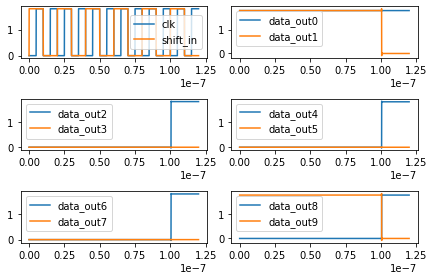

In [24]:
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()
import yaml
#open spice file and check whether VSS is before VDD or not
spec = "./laygo2_example/scan/scan_spec.yaml"
with open(spec, 'r') as stream:
   specdict = yaml.load(stream, Loader=yaml.FullLoader)
bit = specdict['bit']
_FIRST = 'VDD'
spice_file = "./scan_chain_%dbit.spice" %(bit)
f = open(spice_file,'r')
line = f.readline()
terms = line.split()
while 'VDD' not in terms and 'VSS' not in terms:
    line = f.readline()
    terms = line.split()
if 'VSS' not in terms:
    pass # VDD first
elif 'VDD' not in terms:
    _FIRST = 'VSS'
else:
    if terms.index('VSS') < terms.index('VDD'):
        _FIRST = 'VSS'
    else:
        pass # VDD first
f.close()
#set pin list of chain
pin_list = ['clk','clk_out']
for idx in range(bit):
    # pin_list.append('data_in<%d>'%(idx))
    pin_list.append('data_in')
for idx in range(bit):
    pin_list.append('data_out%d'%(idx))
pin_list.extend(['enable','reset'])
for idx in range(bit):
    # pin_list.append('reset_val<%d>'%(idx))
    pin_list.append('reset_val')
pin_list.extend(['shift_in','data_load','shift_out'])
if _FIRST == 'VSS':
    pin_list.extend(['0','VDD'])
else:
    pin_list.extend(['VDD','0'])

circuit = Circuit('tb_scan_chain_%dbit'%(bit))
circuit.lib('/usr/local/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice', 'tt')
circuit.include(spice_file)
circuit.X('SCH','scan_chain_%dbit'%(bit),' '.join(pin_list))
circuit.V('power', 'VDD', circuit.gnd, 1.8)
circuit.V('dat', 'data_in', circuit.gnd, 1.8)
circuit.V('load', 'data_load', circuit.gnd, 0)
circuit.V('reset', 'reset', circuit.gnd, 0)
circuit.V('reset_val', 'reset_val', circuit.gnd, 1.8)
circuit.PulseVoltageSource('ser', 'shift_in', circuit.gnd,
                           initial_value=0@u_V, pulsed_value=1.8@u_V,
                           rise_time=0.01@u_ns, fall_time=0.01@u_ns,
                           pulse_width=10@u_ns, period=20@u_ns, delay_time=0@u_ns)
circuit.PulseVoltageSource('clk', 'clk', circuit.gnd,
                           initial_value=0@u_V, pulsed_value=1.8@u_V,
                           rise_time=0.01@u_ns, fall_time=0.01@u_ns,
                           pulse_width=5@u_ns, period=10@u_ns, delay_time=5@u_ns)
circuit.PulseVoltageSource('en', 'enable', circuit.gnd,
                           initial_value=0@u_V, pulsed_value=1.8@u_V,
                           rise_time=0.01@u_ns, fall_time=0.01@u_ns,
                           pulse_width=100@u_ns, period=110@u_ns, delay_time=0@u_ns)
print(circuit)
print('simulation start')
simulator = circuit.simulator()
analysis = simulator.transient(step_time=1@u_ns, end_time=120@u_ns)
print('done')
subplotNum = int(bit/2)+ + bit%2
rows = int(subplotNum/2)+1

plt.subplot(rows,2,1)
plt.plot(np.array(analysis.time), np.array(analysis['clk']))
plt.plot(np.array(analysis.time), np.array(analysis['shift_in']))
plt.legend(('clk', 'shift_in'))

for idx in range(subplotNum-1):
    plt.subplot(rows,2,idx+2)
    plt.plot(np.array(analysis.time), np.array(analysis['data_out%d'%(idx*2)]))
    plt.plot(np.array(analysis.time), np.array(analysis['data_out%d'%(idx*2+1)]))
    plt.legend(('data_out%d'%(idx*2), 'data_out%d'%(idx*2+1)))    
if bit%2 == 1:
    plt.subplot(rows,2,subplotNum+1)
    plt.plot(np.array(analysis.time), np.array(analysis['data_out%d'%(bit-1)]))
    plt.legend(('data_out%d'%(bit-1)))
else:
    plt.subplot(rows,2,subplotNum+1)
    plt.plot(np.array(analysis.time), np.array(analysis['data_out%d'%(bit-2)]))
    plt.plot(np.array(analysis.time), np.array(analysis['data_out%d'%(bit-1)]))
    plt.legend(('data_out%d'%(bit-2), 'data_out%d'%(bit-1)))    
plt.tight_layout()
plt.savefig('./scan_chain_10bit_sim.png')
plt.show()